***
#### Results

In [76]:
network = NN(layer_nodes,number_of_inputs, number_of_outputs, learning_rate)

In [91]:
nu = np.arange(1024)
num_samples = 10000
testing = checker(num = num_samples)
actls = np.array(testing).T[0]
preds = np.array(testing).T[1]
idx = np.argsort(actls)
actls = actls[idx]
preds = preds[idx]

INFO:tensorflow:Restoring parameters from logs/FaoraCopy-A/trained_model.ckpt-2549
9999

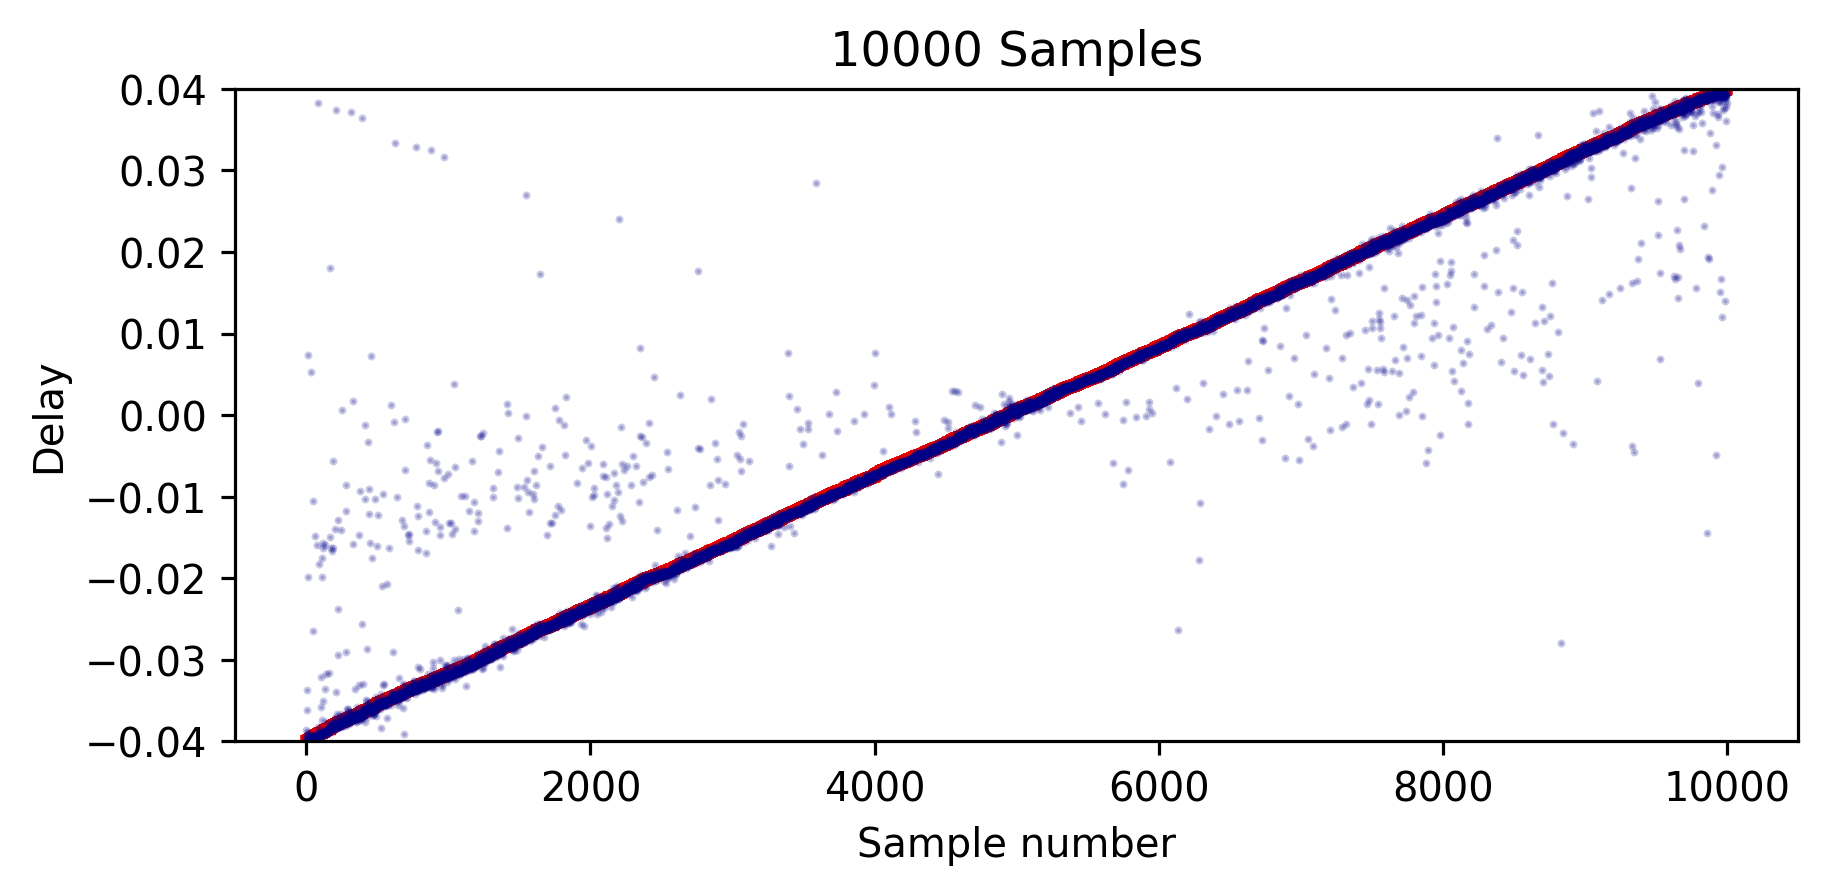

In [93]:
fig, ax = plt.subplots(figsize = (7,3), dpi = 144)
ax.plot(actls, ls = 'None', marker = 's', alpha = 0.5, label = 'Actuals', color = '#E50000', markersize = 2)
ax.plot(preds, ls = 'None', marker = '.', alpha = 0.21, label = 'Predictions', color = 'darkblue', markersize = 2)
ax.set_ylabel('Delay')
ax.set_xlabel('Sample number')
ax.set_title('%d Samples' %num_samples)
ax.set_ylim(-0.040,0.040)
plt.show()


**Above:** 10,000 samples are fed into the network, each sample produces 60 predictions. A histogram of the predictions is made for each sample, I then attempt to fit a gaussian to that histogram. If it succeeds then the prediction is $\mu$ for that fit, if it fails the prediction is just the mean of the predictions.

In [102]:
print('%.2f%% within 0.0000001 ' %(100*np.mean(preds - actls < 0.000001)))
print('%.2f%% within 0.0001 (approx 1ns)' %(100*np.mean(preds - actls < 0.0001)))
print('%.2f%% within 0.0005 (approx 5ns)' %(100*np.mean(preds - actls < 0.0005)))

61.53% within 0.0000001 
73.98% within 0.0001 (approx 1ns)
93.07% within 0.0005 (approx 5ns)


**Below:** 25 Random samples are shown with their actual and predicted values.

Left plot: The sample NN input.

Middle plot: Prediction compared to actual for each row in the sample input. 

Right plot: Histogram of the predictions, the green dashed line is the actual value. It tries to fit a gaussian to the histogram, if it succeeds then the title is the $\mu$ and $\sigma$ for that fit, if it fails the title is just the mean of the predictions. Sometimes the gaussian succeeds but it is a *terrible* fit, I havent bothered to check for this yet. 


INFO:tensorflow:Restoring parameters from logs/FaoraCopy-A/trained_model.ckpt-2549


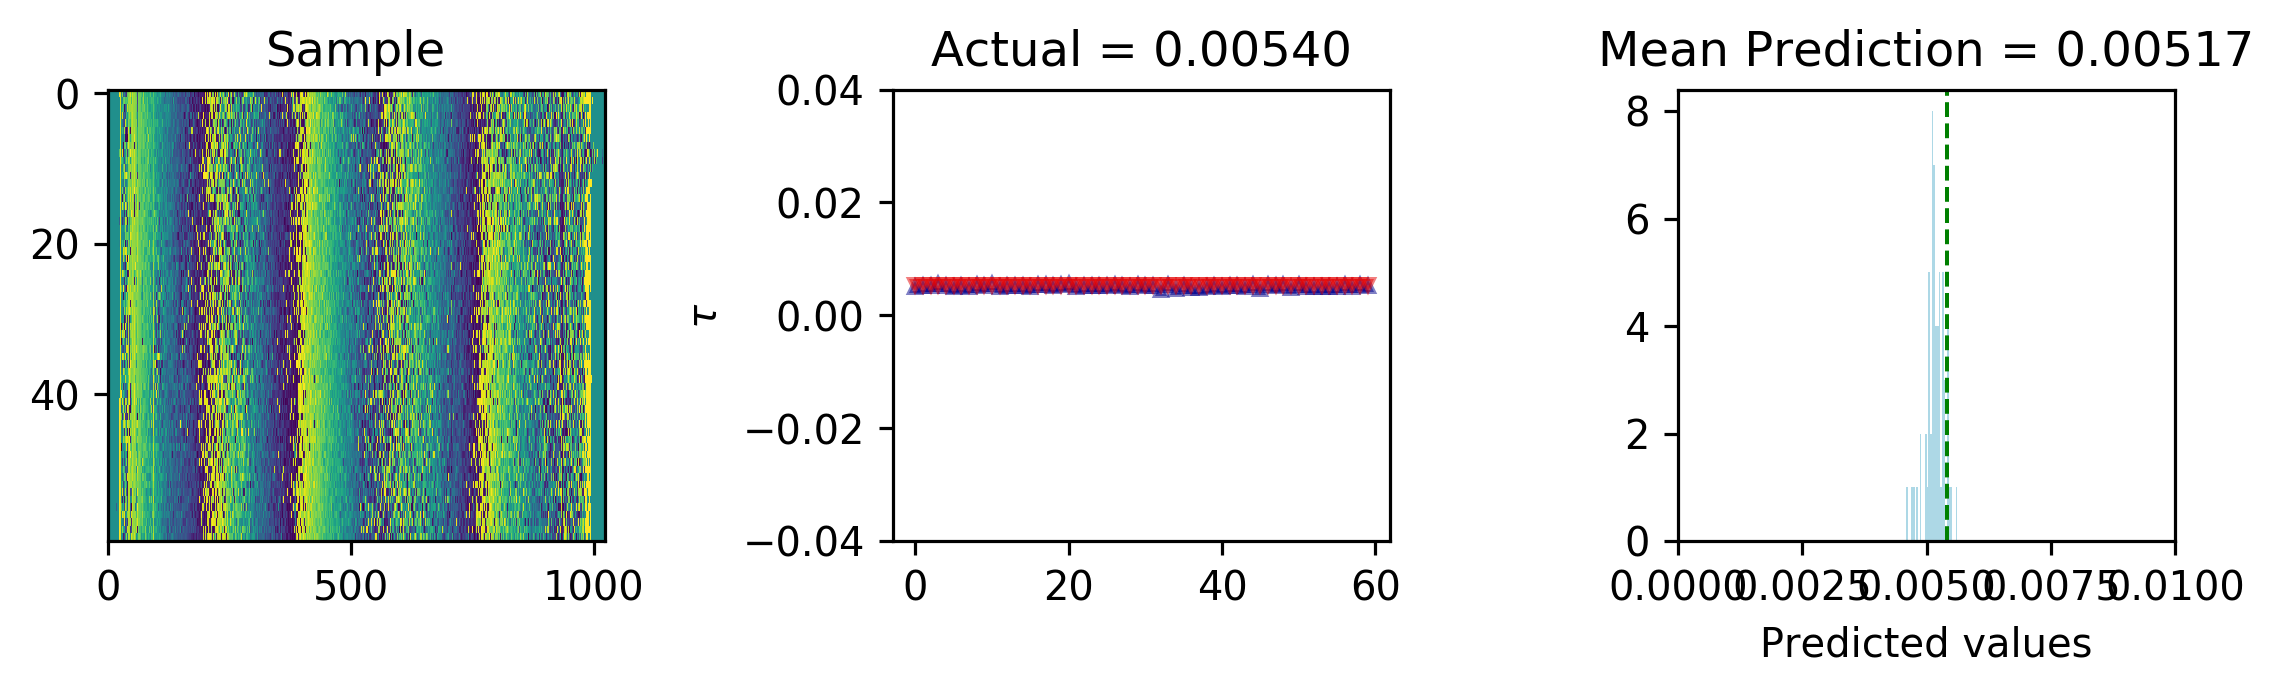

INFO:tensorflow:Restoring parameters from logs/FaoraCopy-A/trained_model.ckpt-2549


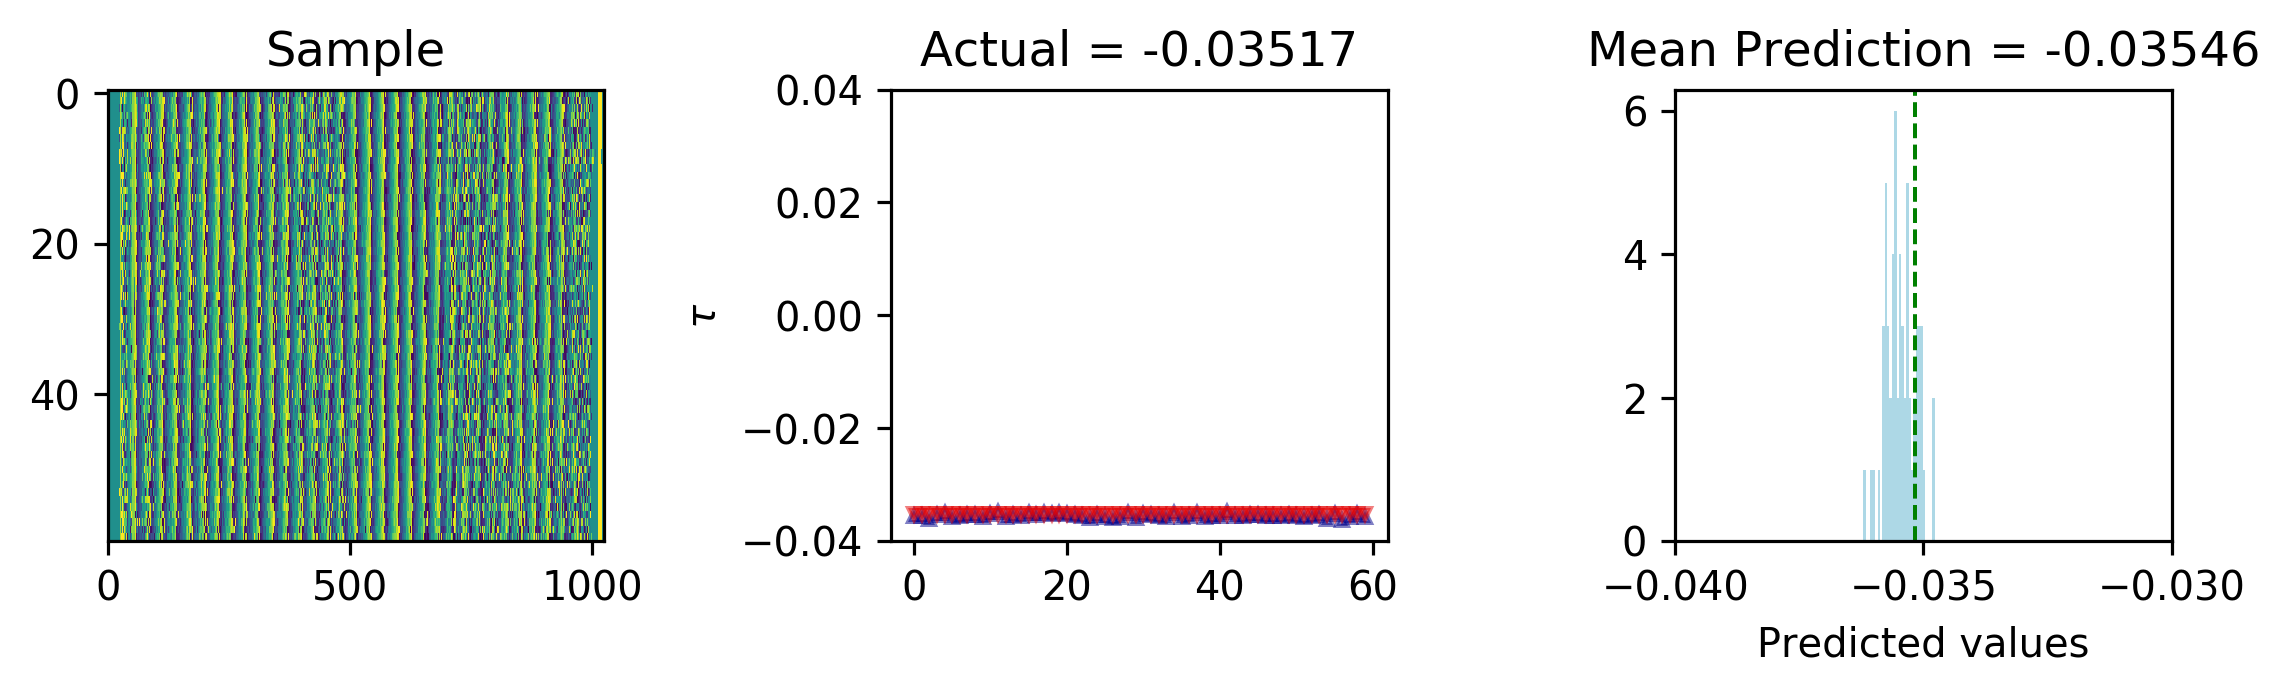

INFO:tensorflow:Restoring parameters from logs/FaoraCopy-A/trained_model.ckpt-2549


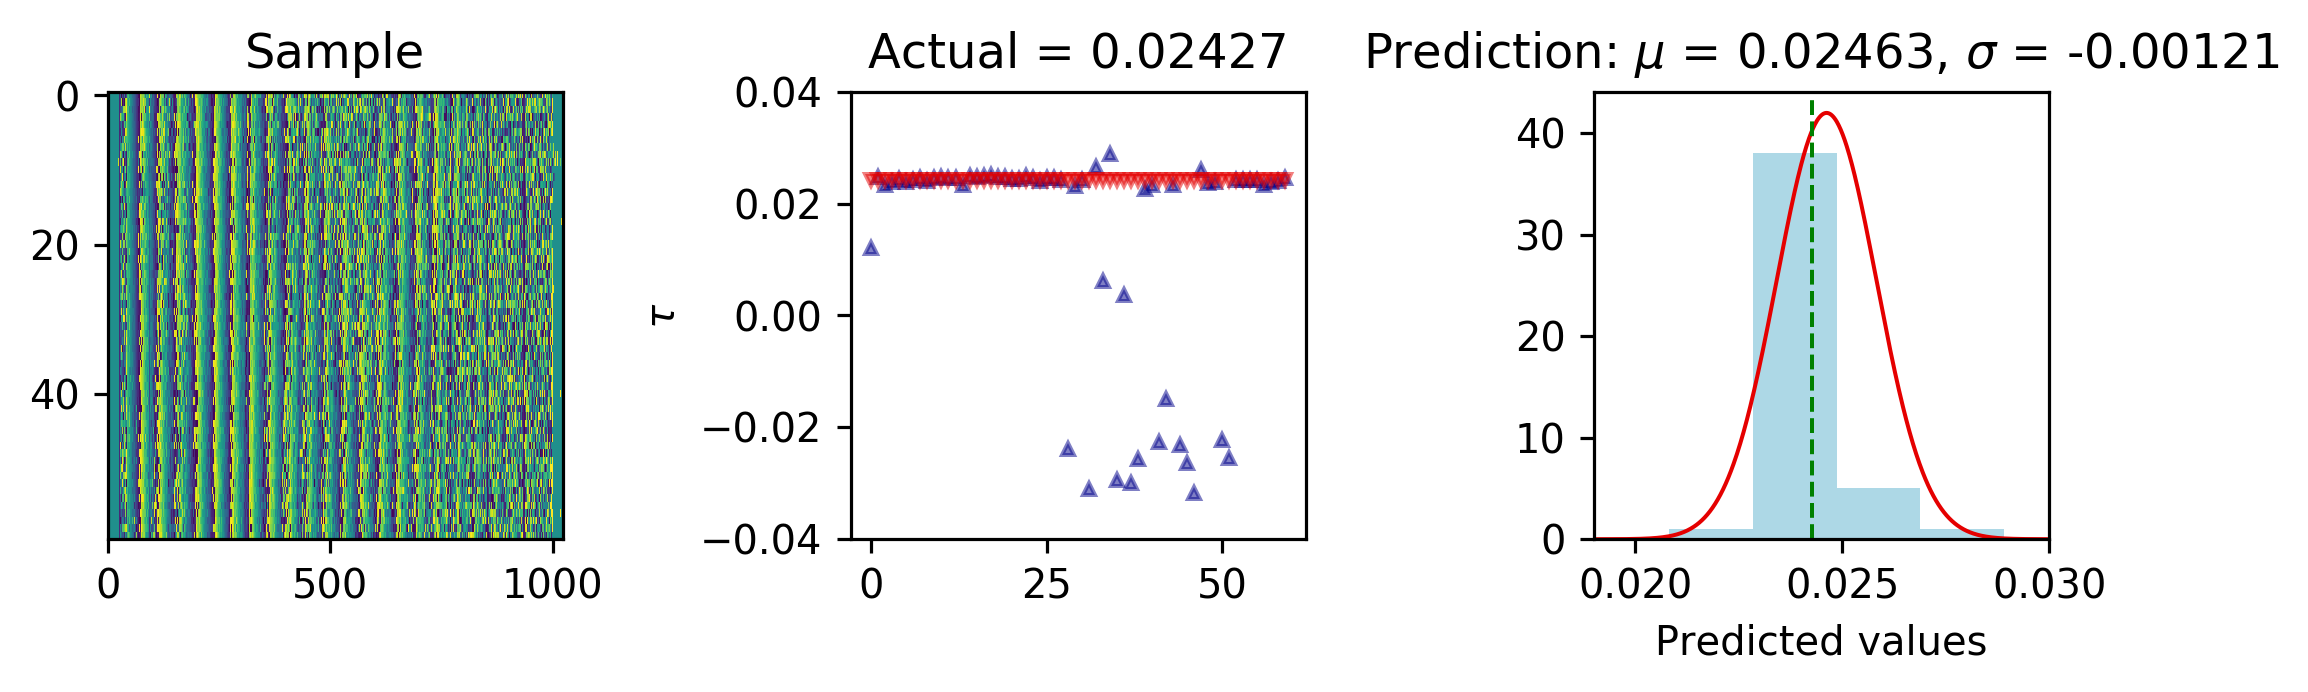

INFO:tensorflow:Restoring parameters from logs/FaoraCopy-A/trained_model.ckpt-2549


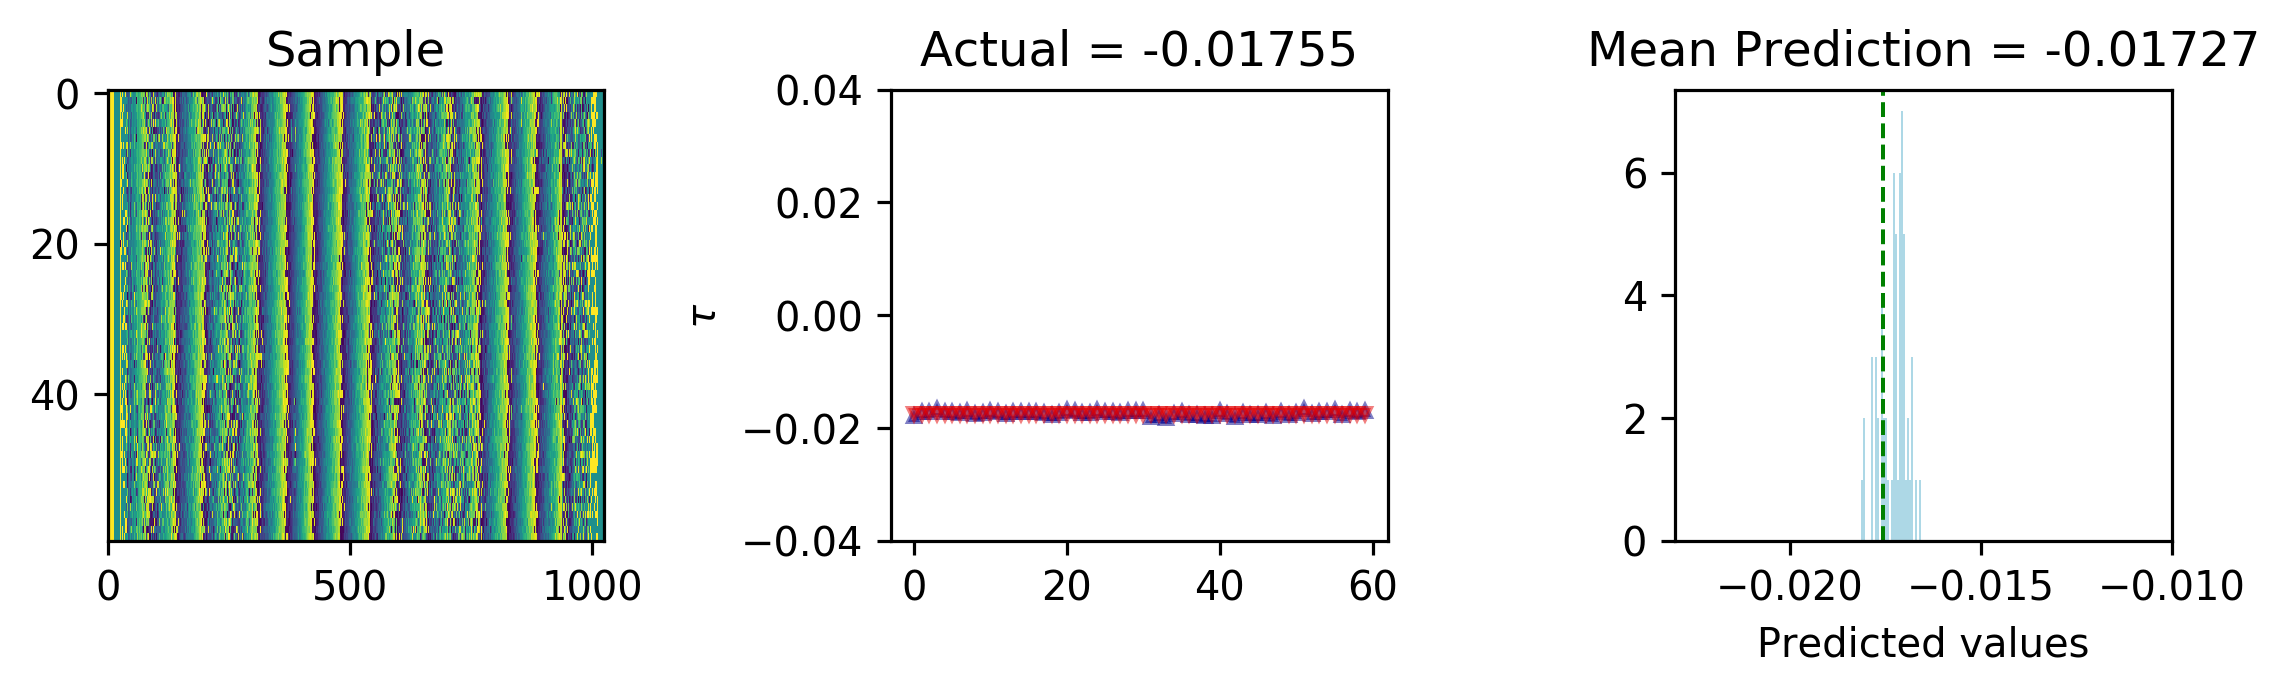

INFO:tensorflow:Restoring parameters from logs/FaoraCopy-A/trained_model.ckpt-2549


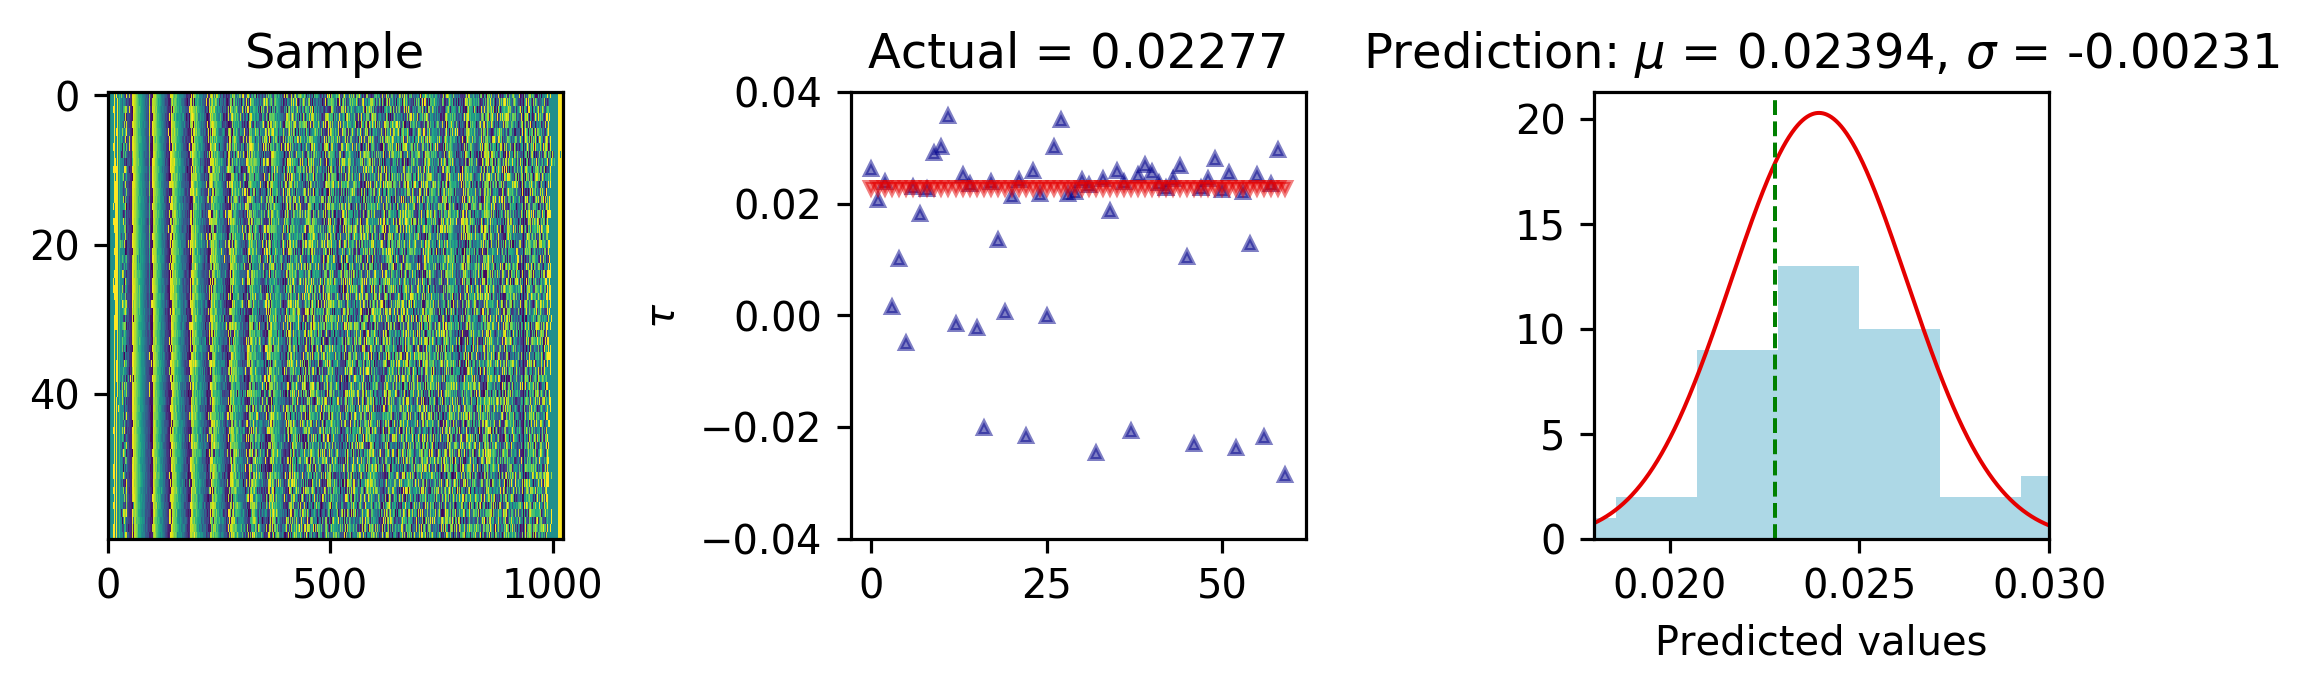

INFO:tensorflow:Restoring parameters from logs/FaoraCopy-A/trained_model.ckpt-2549


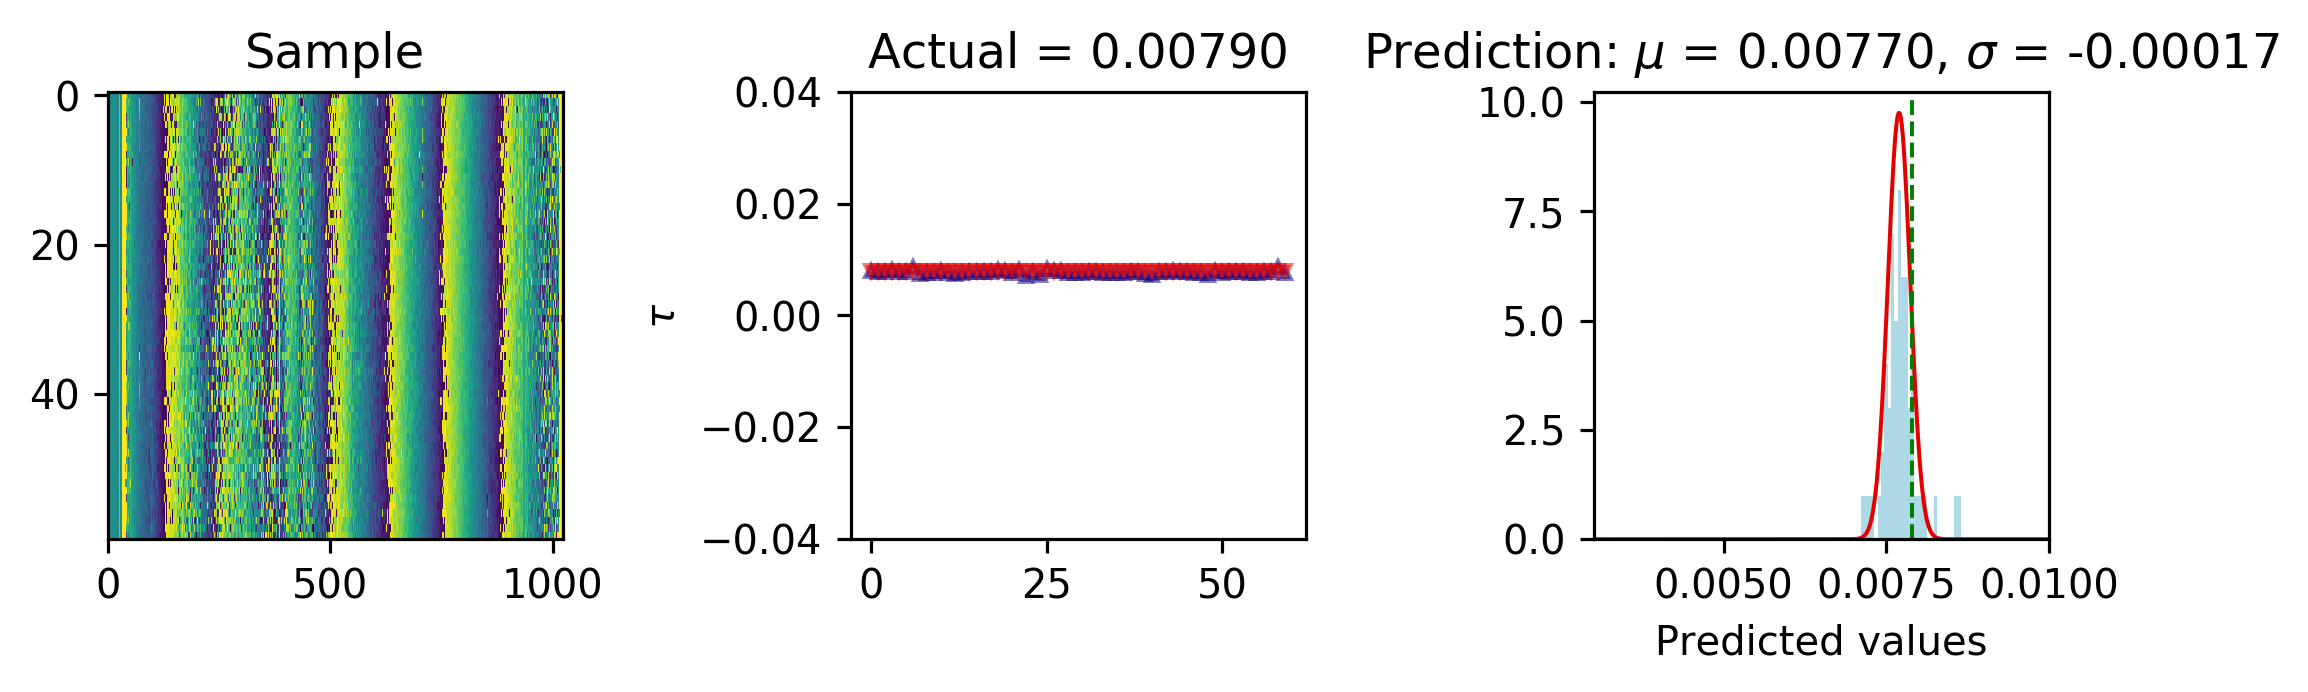

INFO:tensorflow:Restoring parameters from logs/FaoraCopy-A/trained_model.ckpt-2549


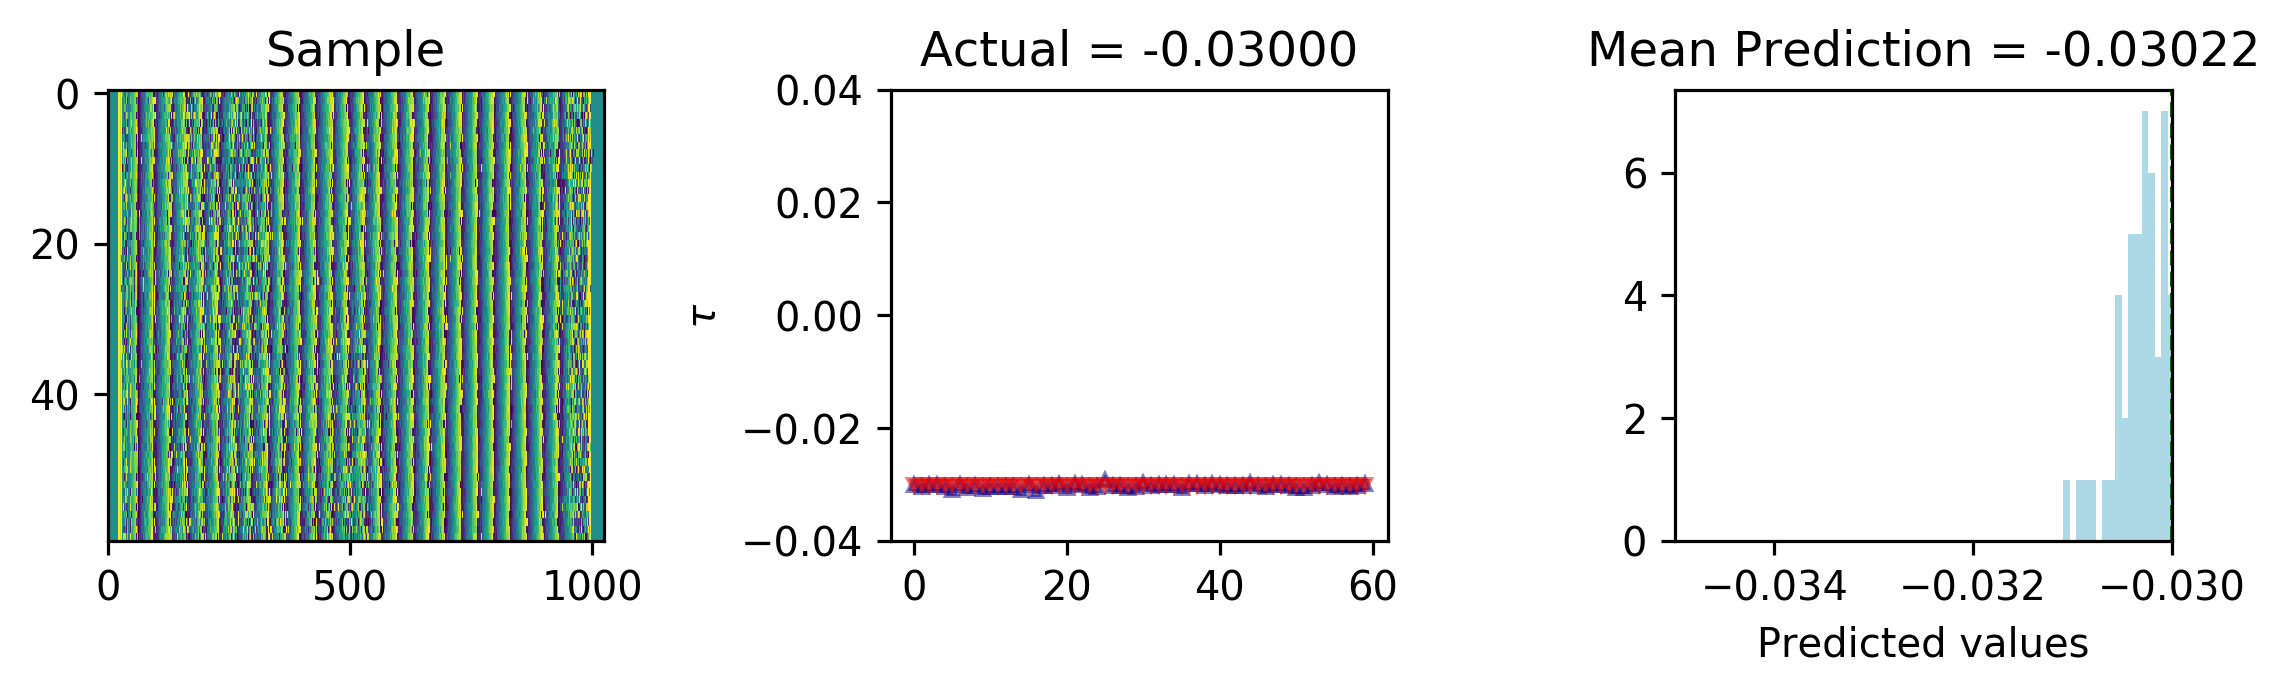

INFO:tensorflow:Restoring parameters from logs/FaoraCopy-A/trained_model.ckpt-2549


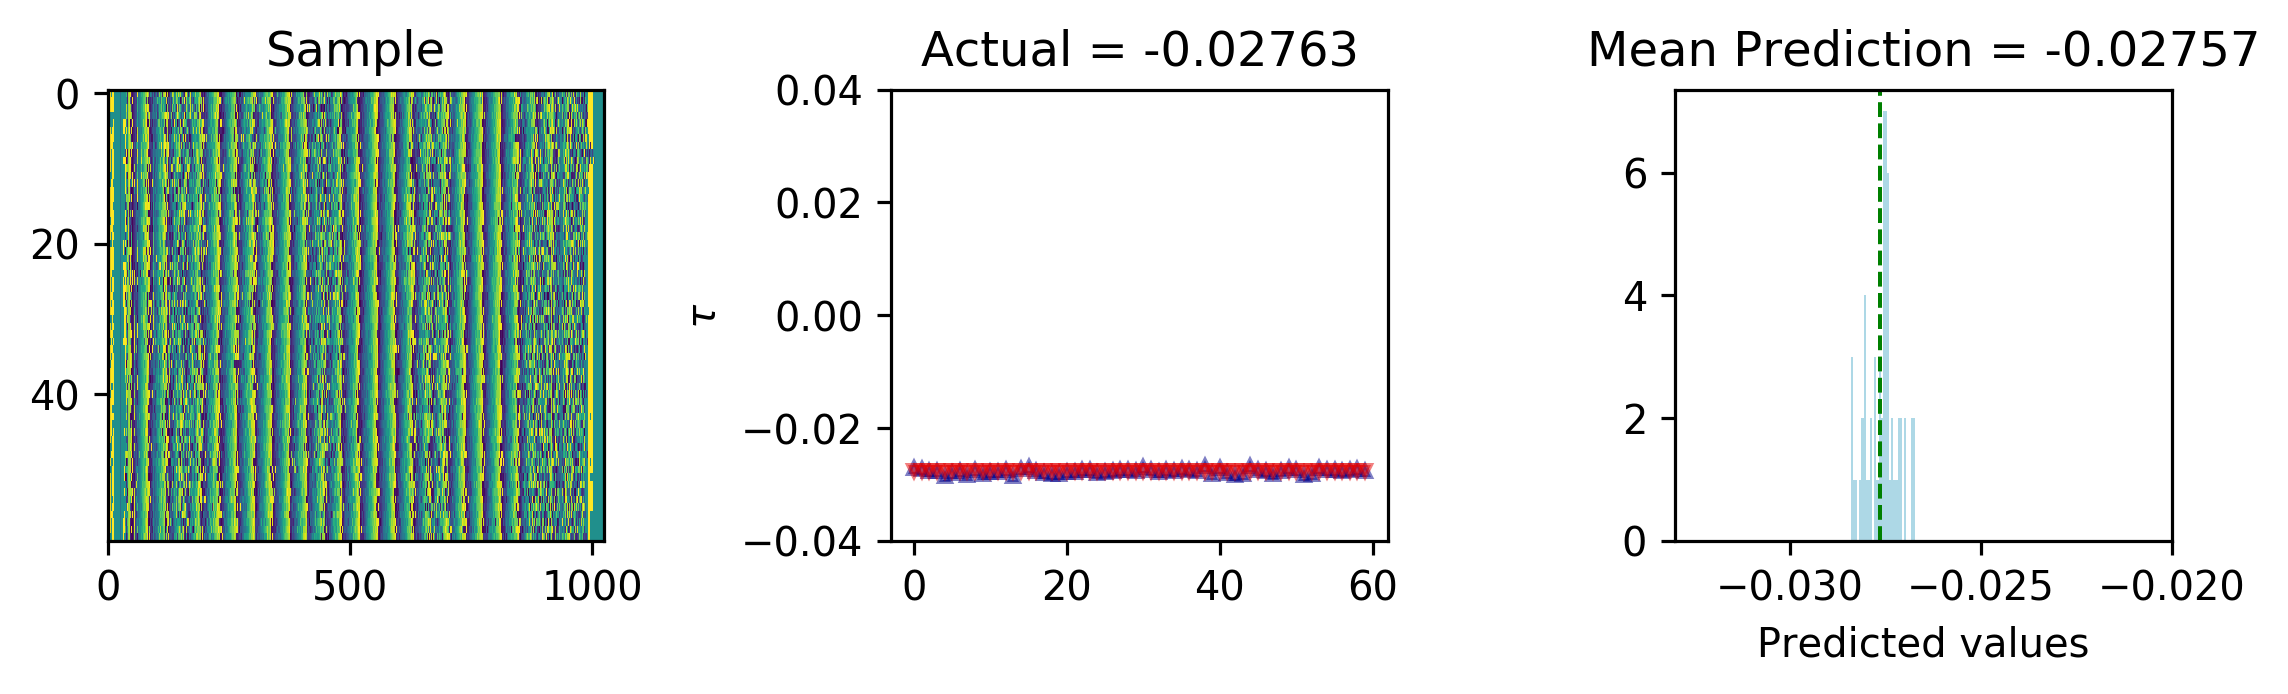

INFO:tensorflow:Restoring parameters from logs/FaoraCopy-A/trained_model.ckpt-2549


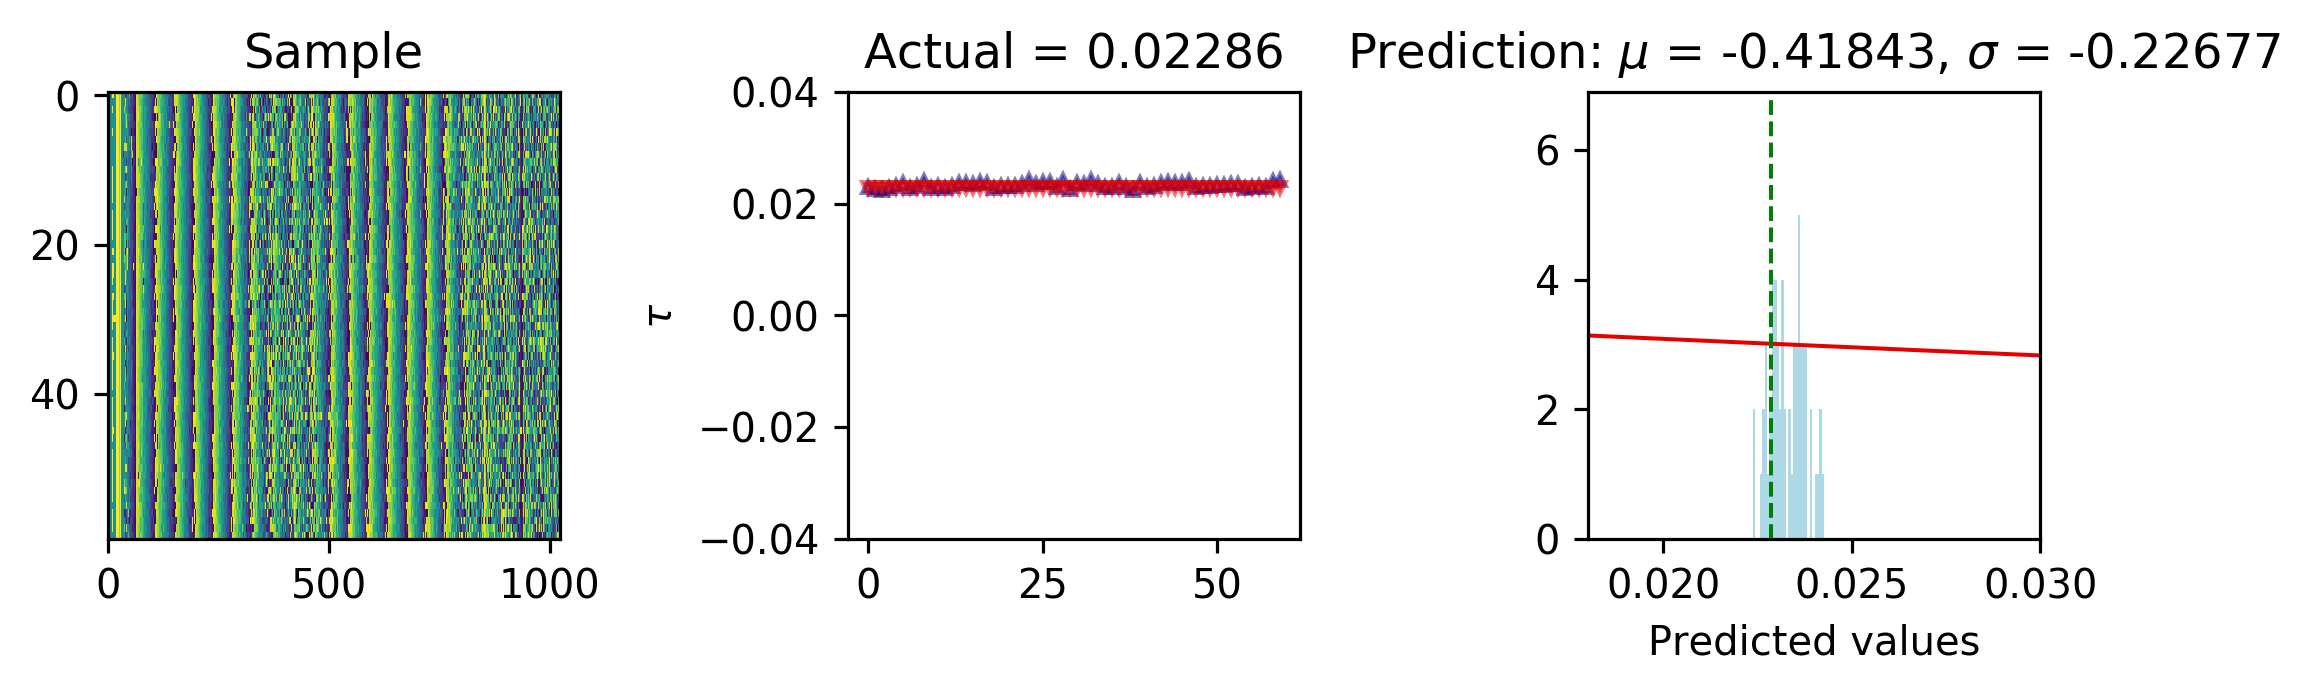

INFO:tensorflow:Restoring parameters from logs/FaoraCopy-A/trained_model.ckpt-2549


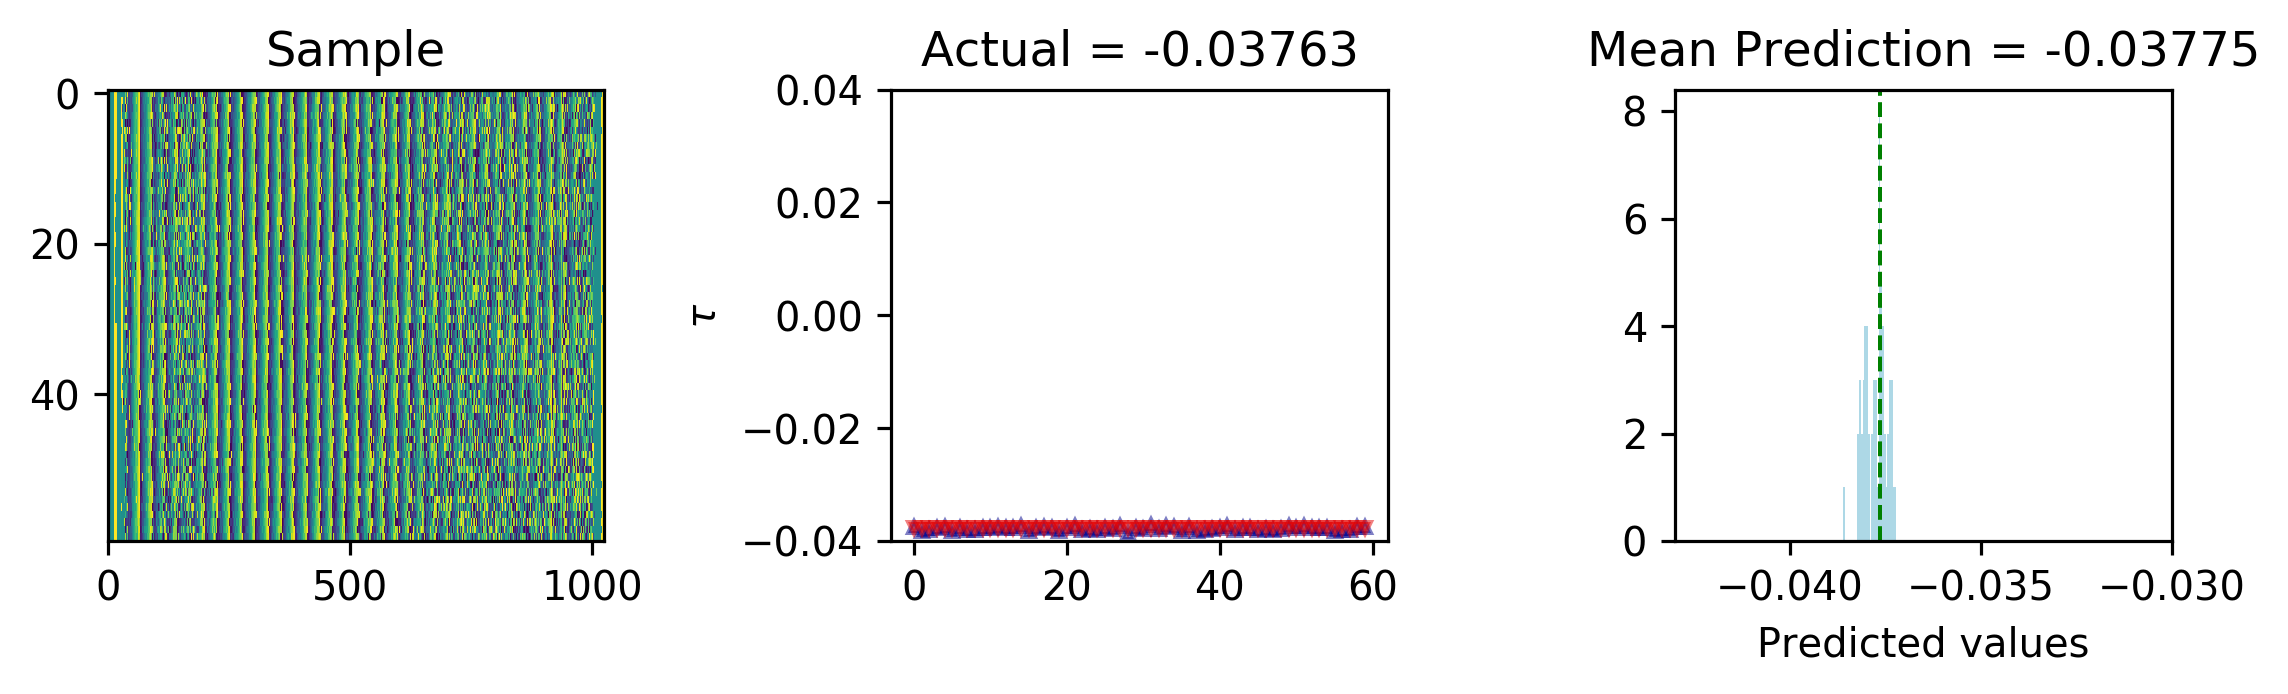

INFO:tensorflow:Restoring parameters from logs/FaoraCopy-A/trained_model.ckpt-2549


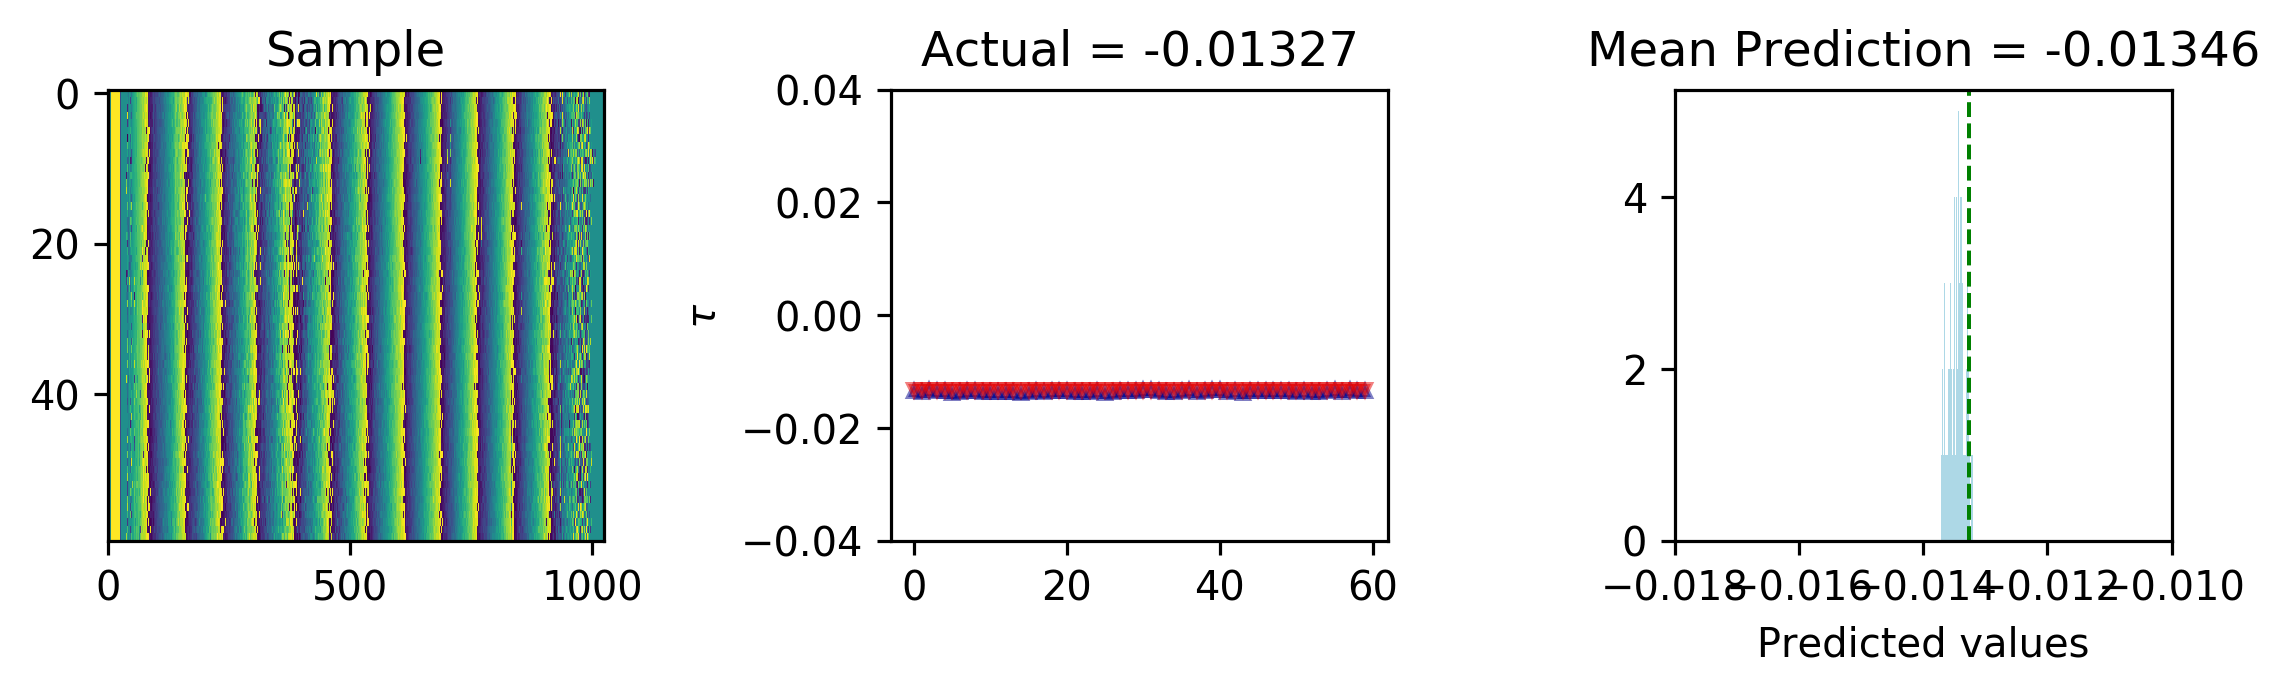

INFO:tensorflow:Restoring parameters from logs/FaoraCopy-A/trained_model.ckpt-2549


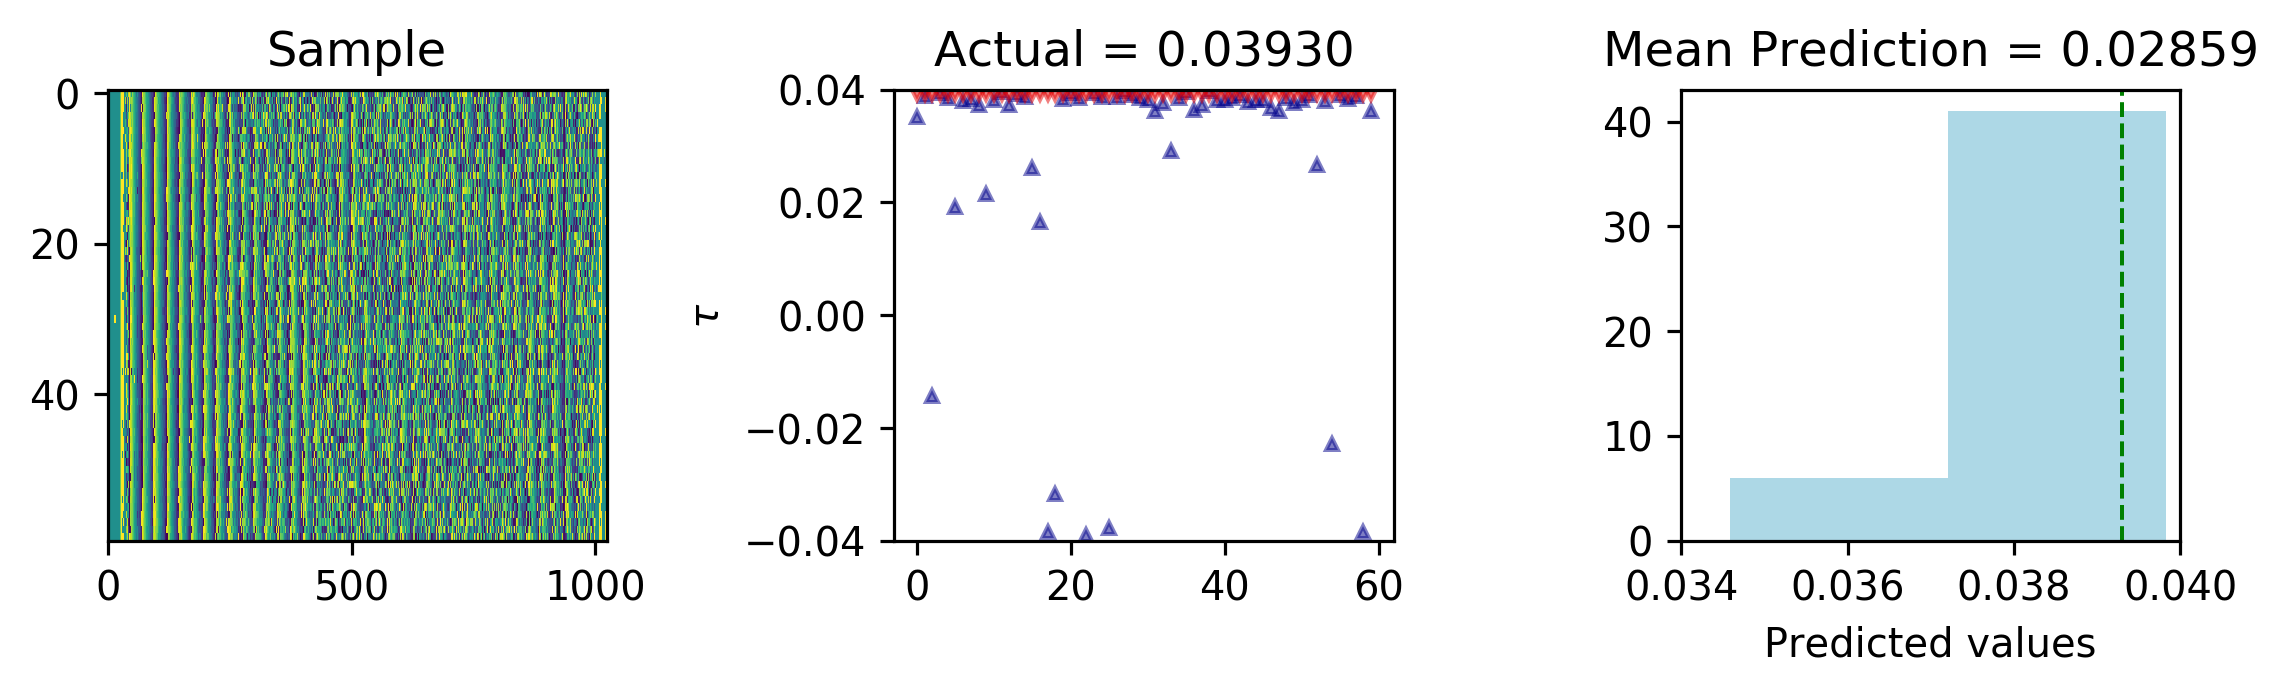

INFO:tensorflow:Restoring parameters from logs/FaoraCopy-A/trained_model.ckpt-2549


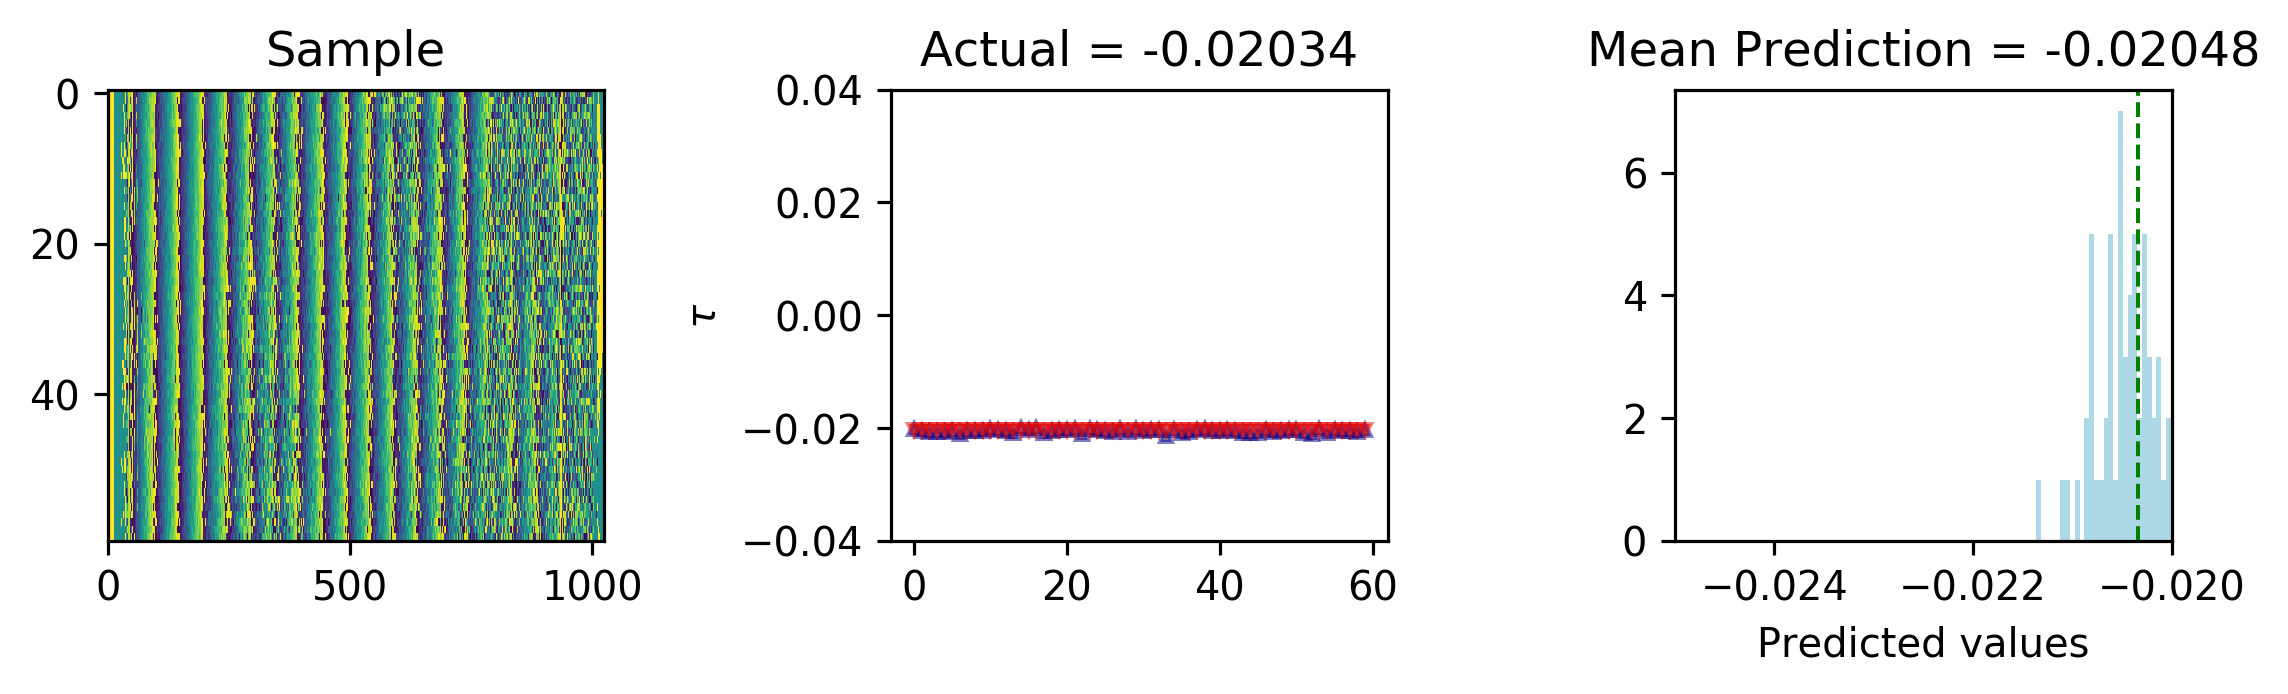

INFO:tensorflow:Restoring parameters from logs/FaoraCopy-A/trained_model.ckpt-2549


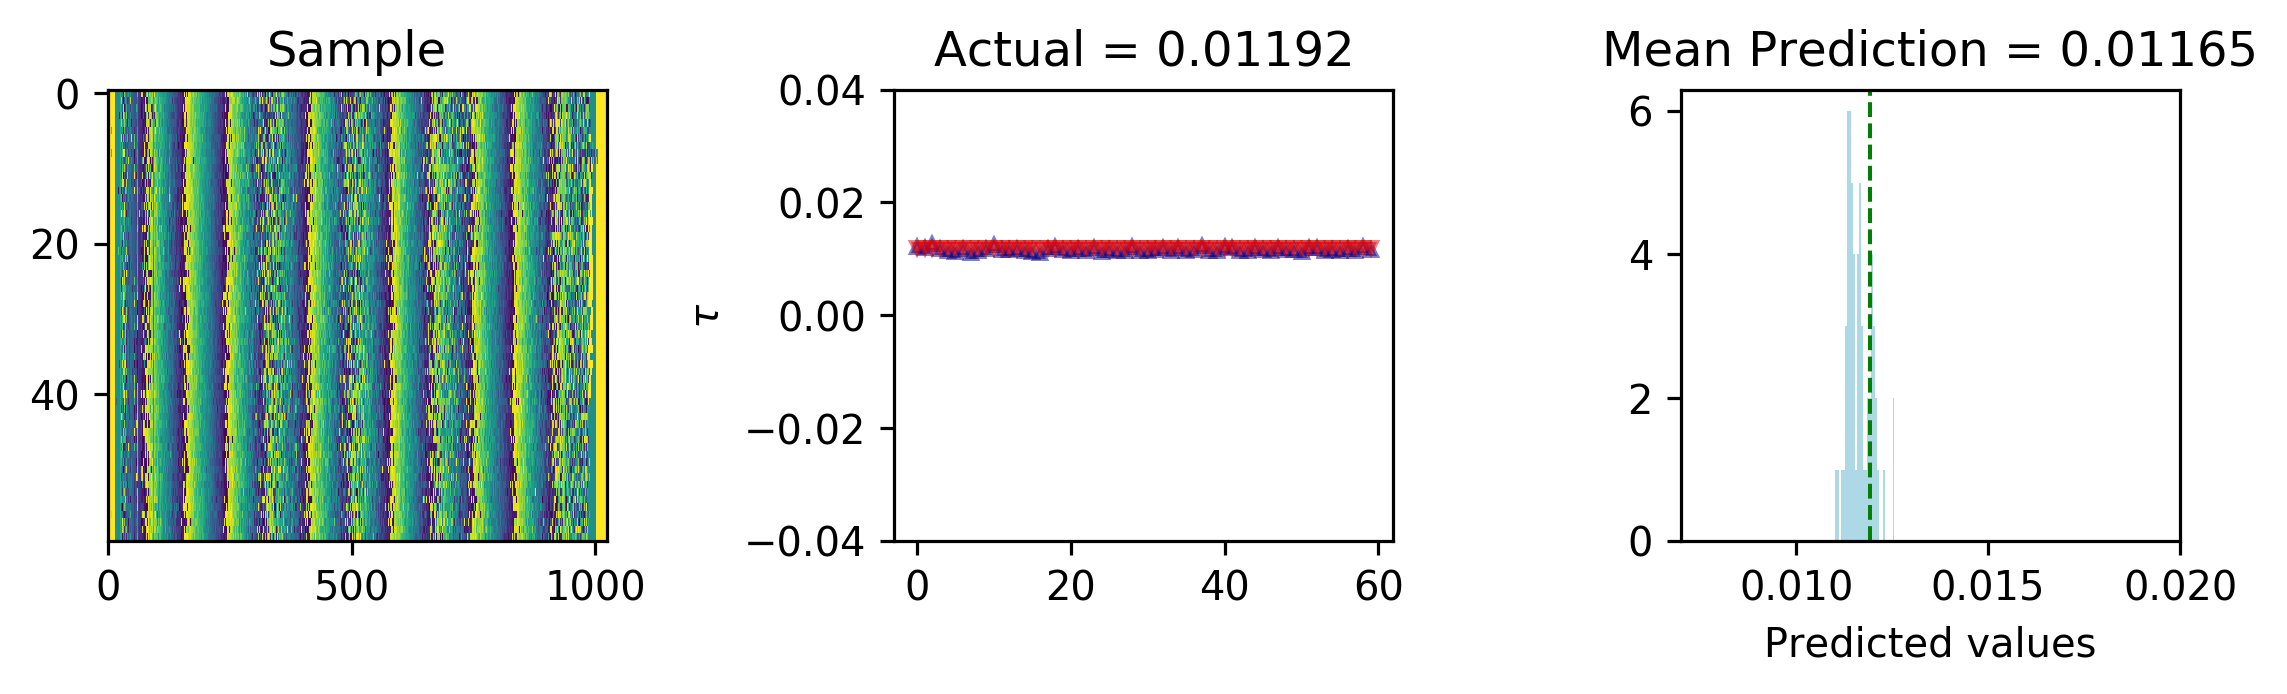

INFO:tensorflow:Restoring parameters from logs/FaoraCopy-A/trained_model.ckpt-2549


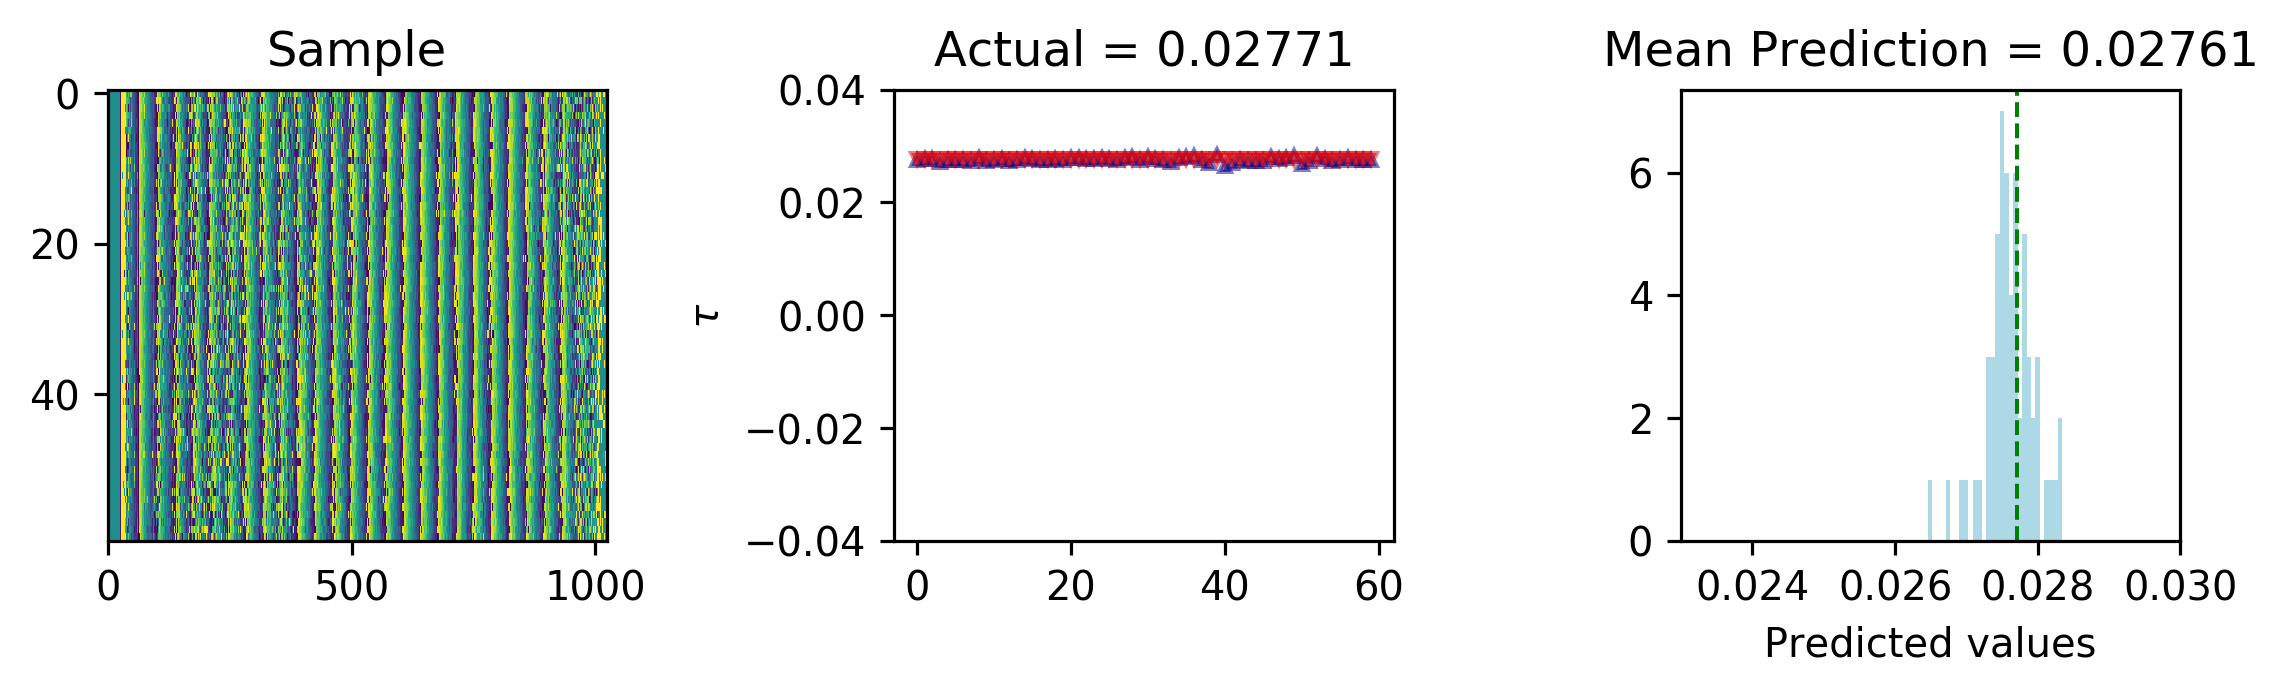

INFO:tensorflow:Restoring parameters from logs/FaoraCopy-A/trained_model.ckpt-2549


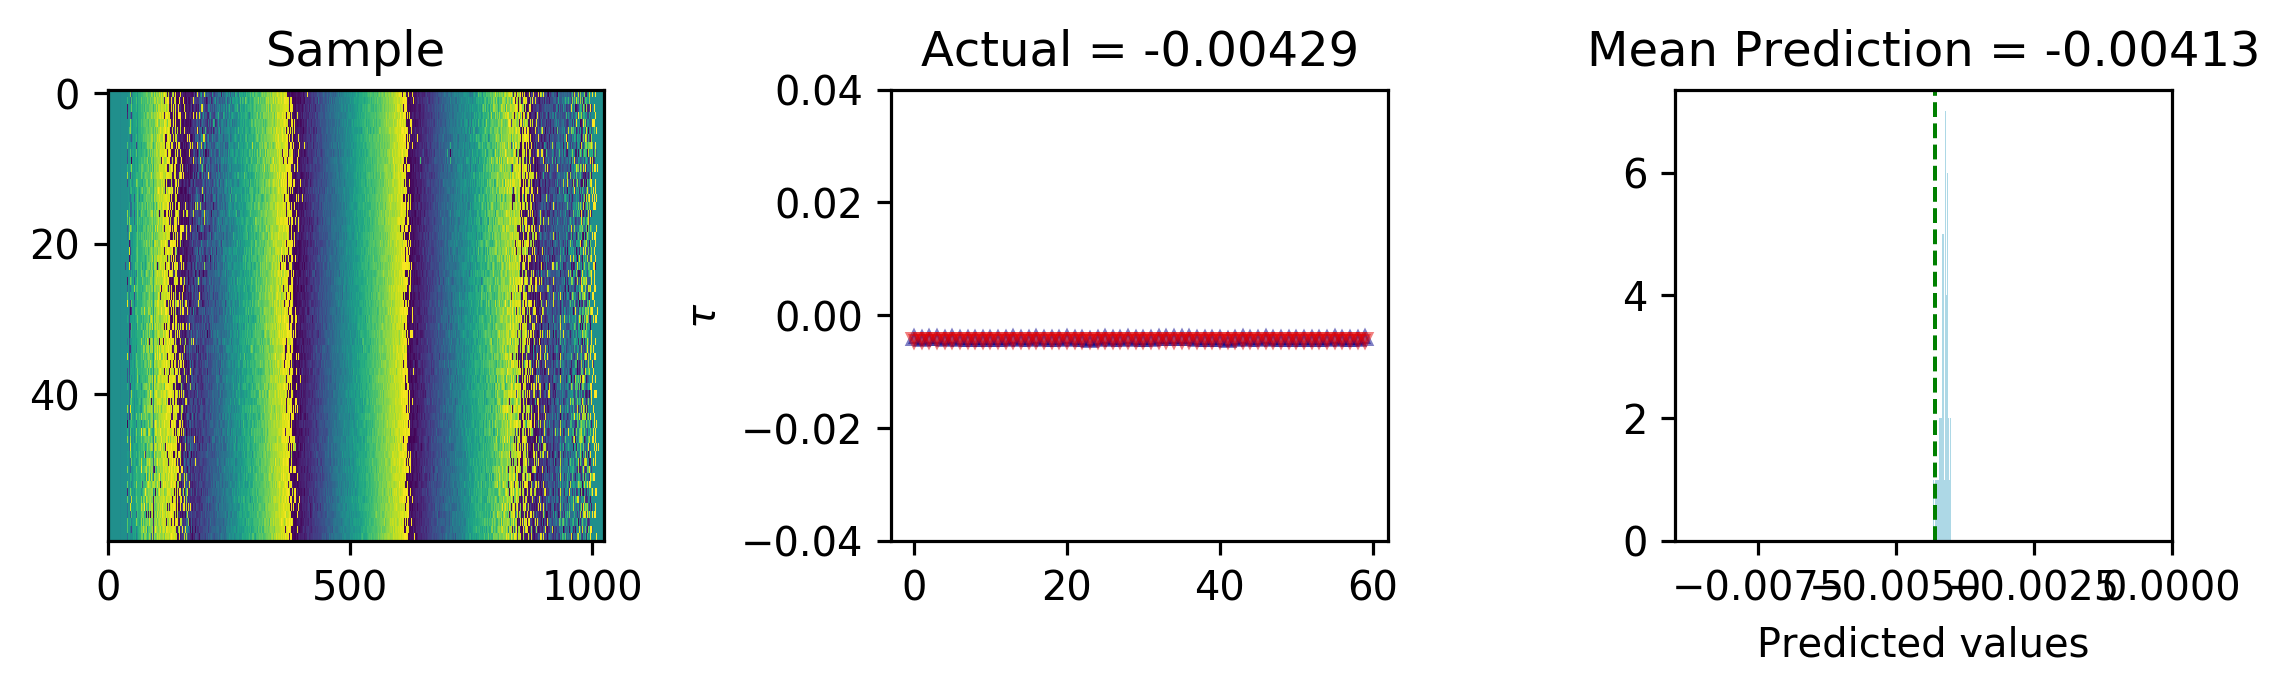

INFO:tensorflow:Restoring parameters from logs/FaoraCopy-A/trained_model.ckpt-2549


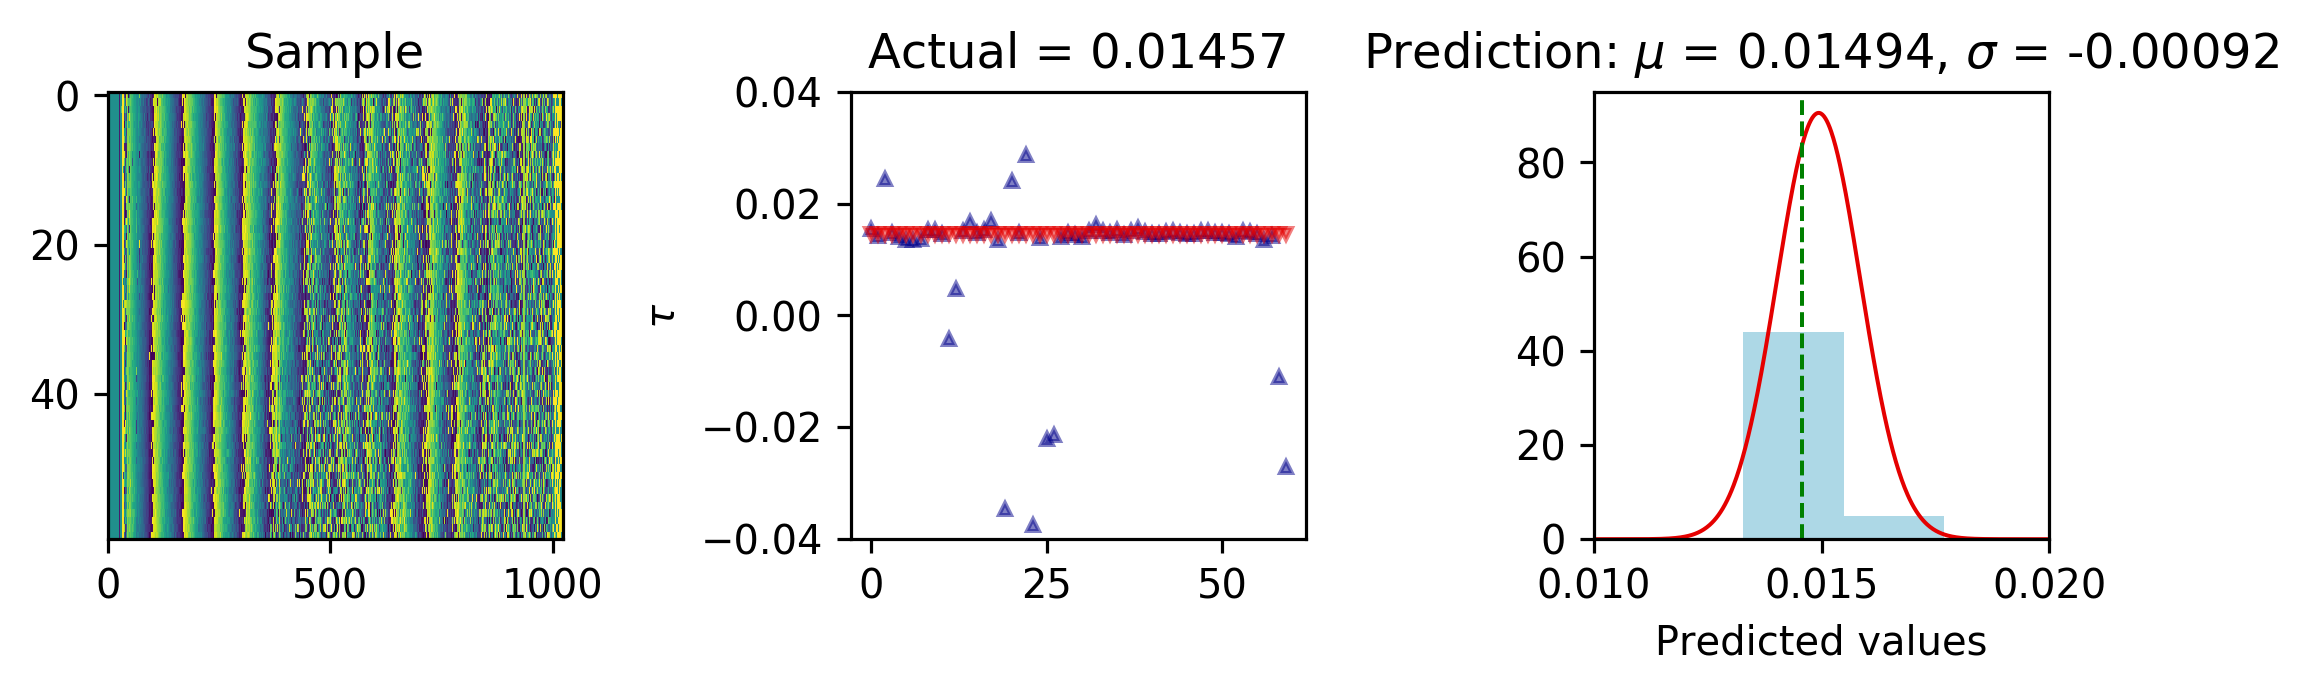

INFO:tensorflow:Restoring parameters from logs/FaoraCopy-A/trained_model.ckpt-2549


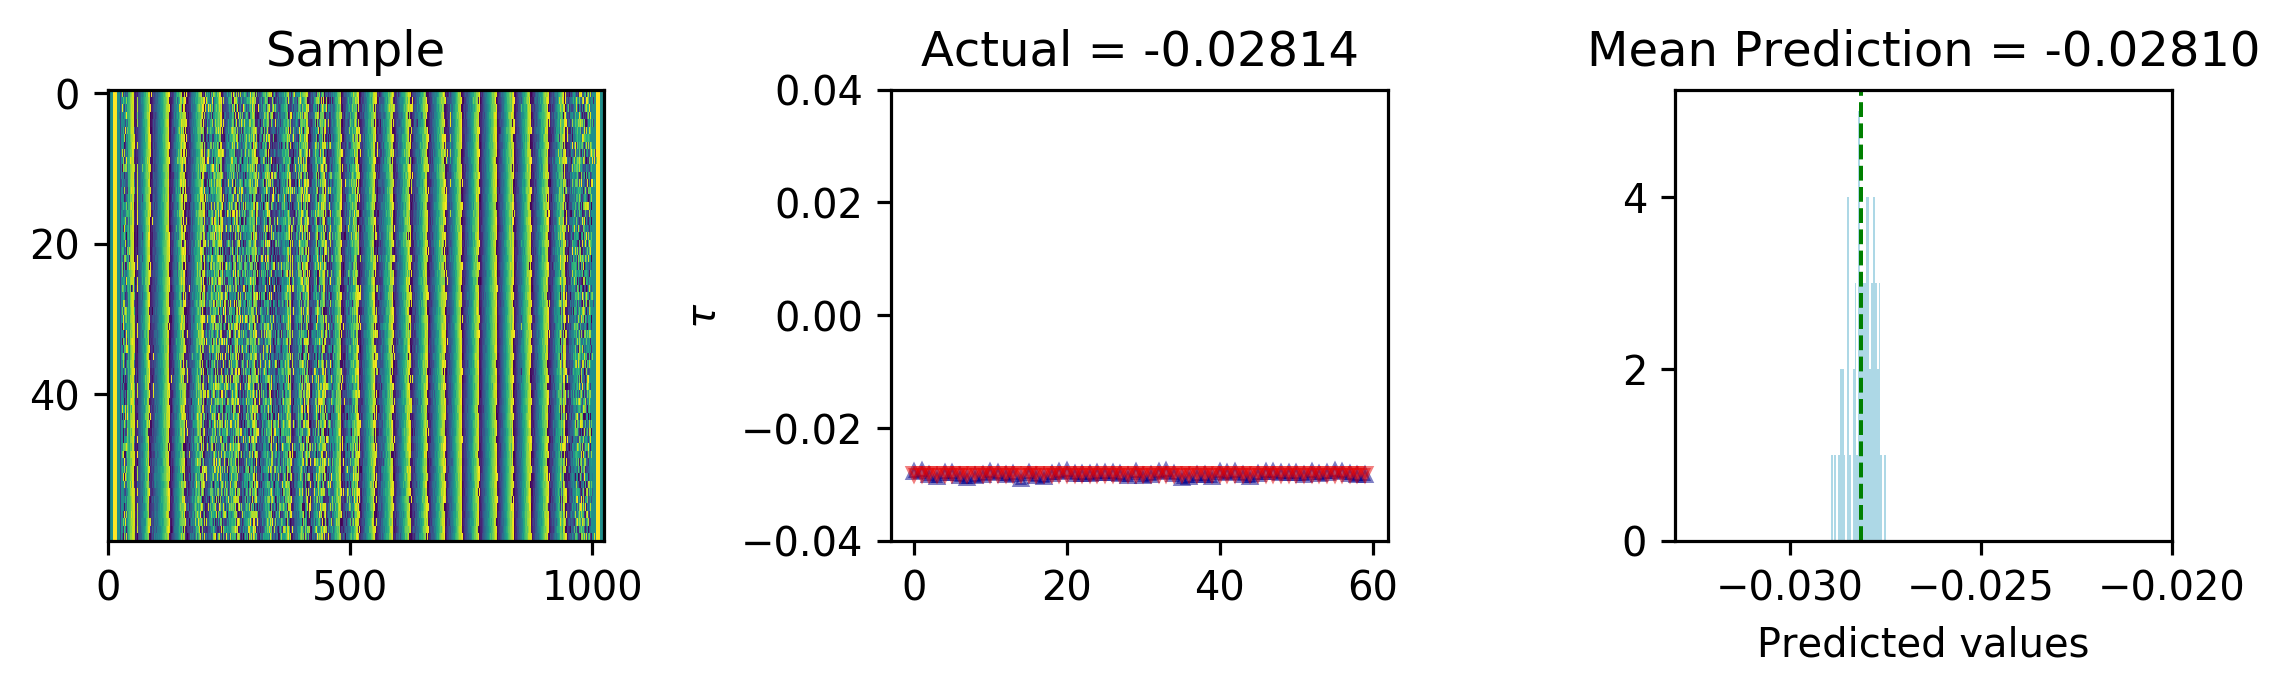

INFO:tensorflow:Restoring parameters from logs/FaoraCopy-A/trained_model.ckpt-2549


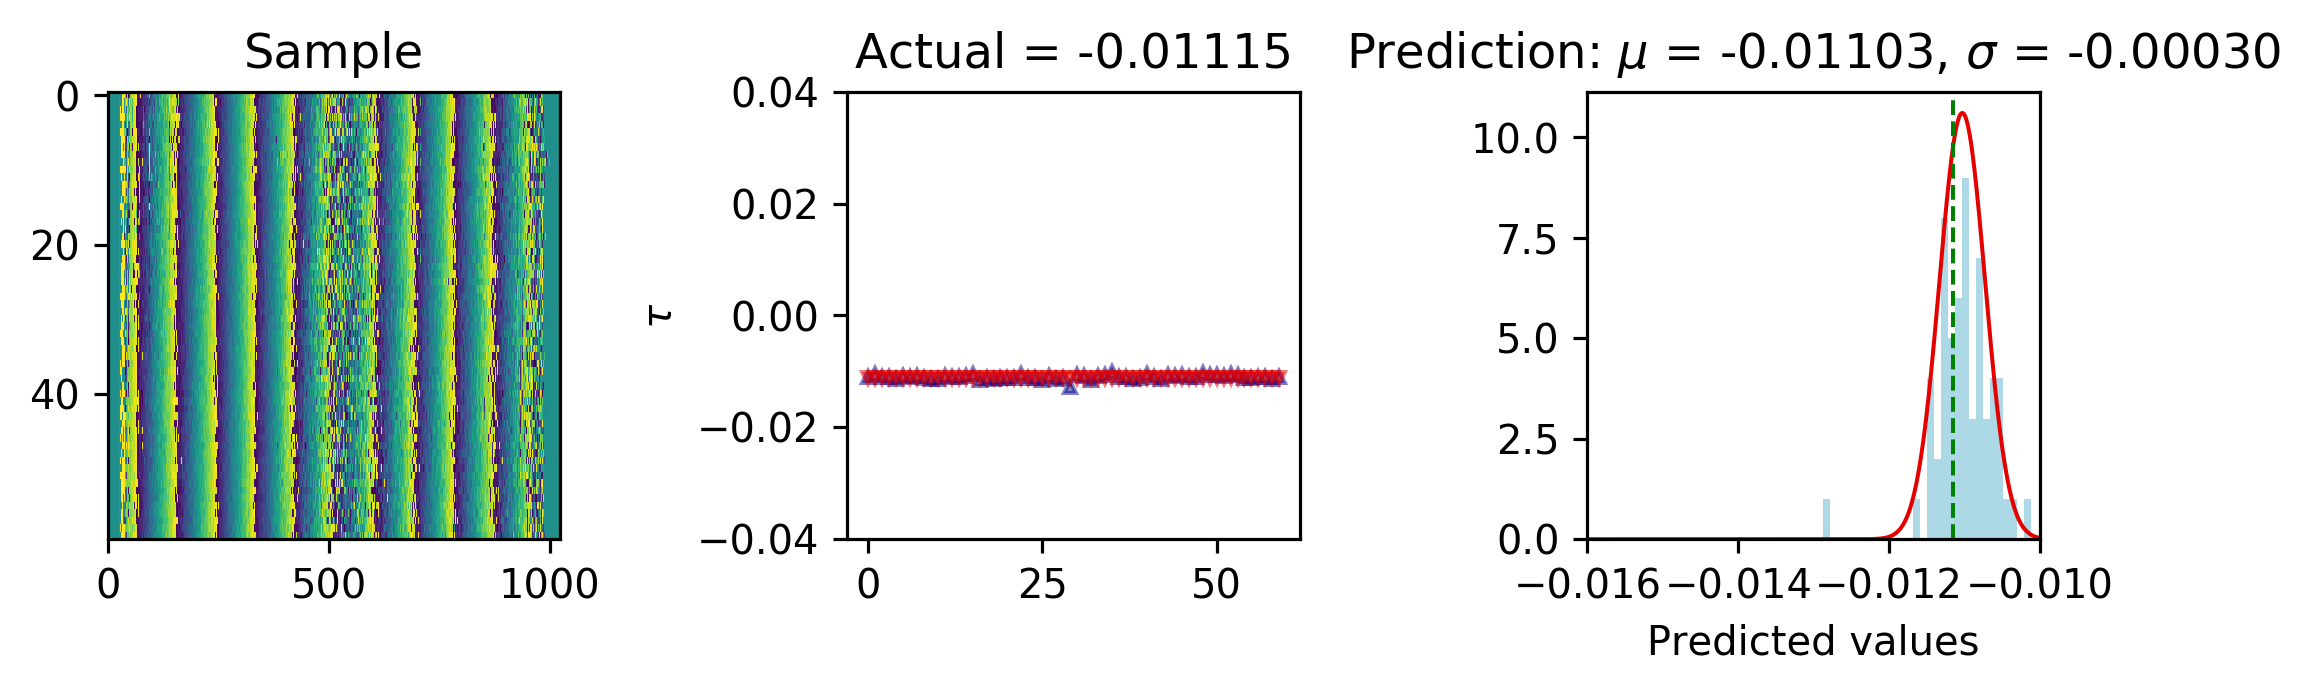

INFO:tensorflow:Restoring parameters from logs/FaoraCopy-A/trained_model.ckpt-2549


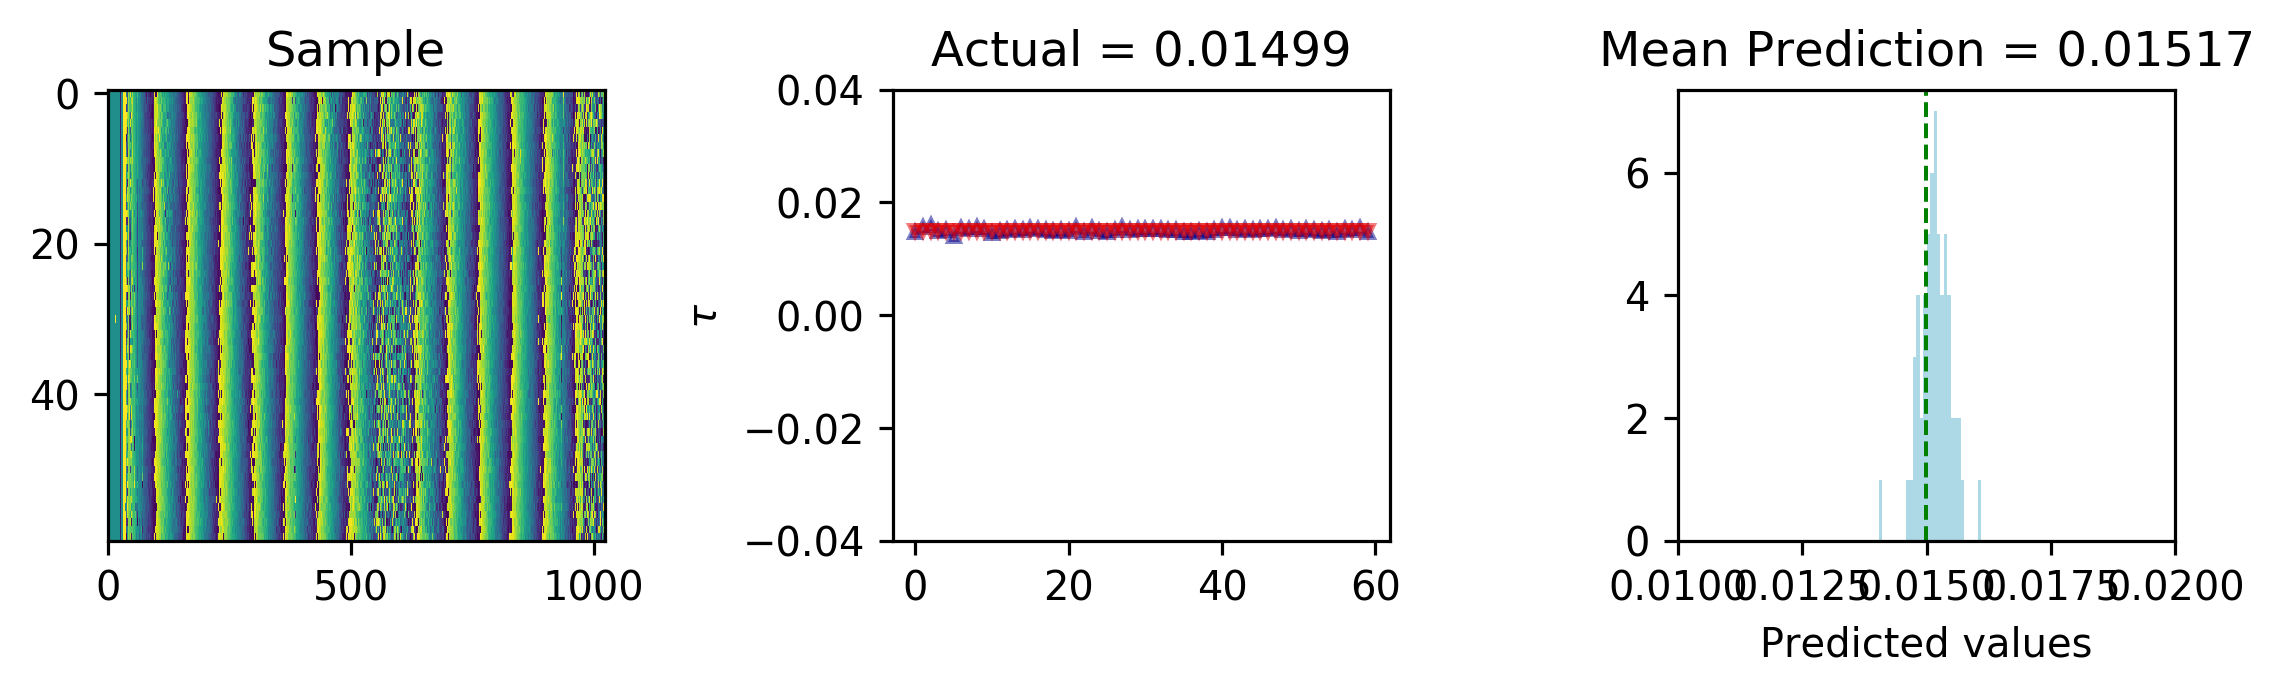

INFO:tensorflow:Restoring parameters from logs/FaoraCopy-A/trained_model.ckpt-2549


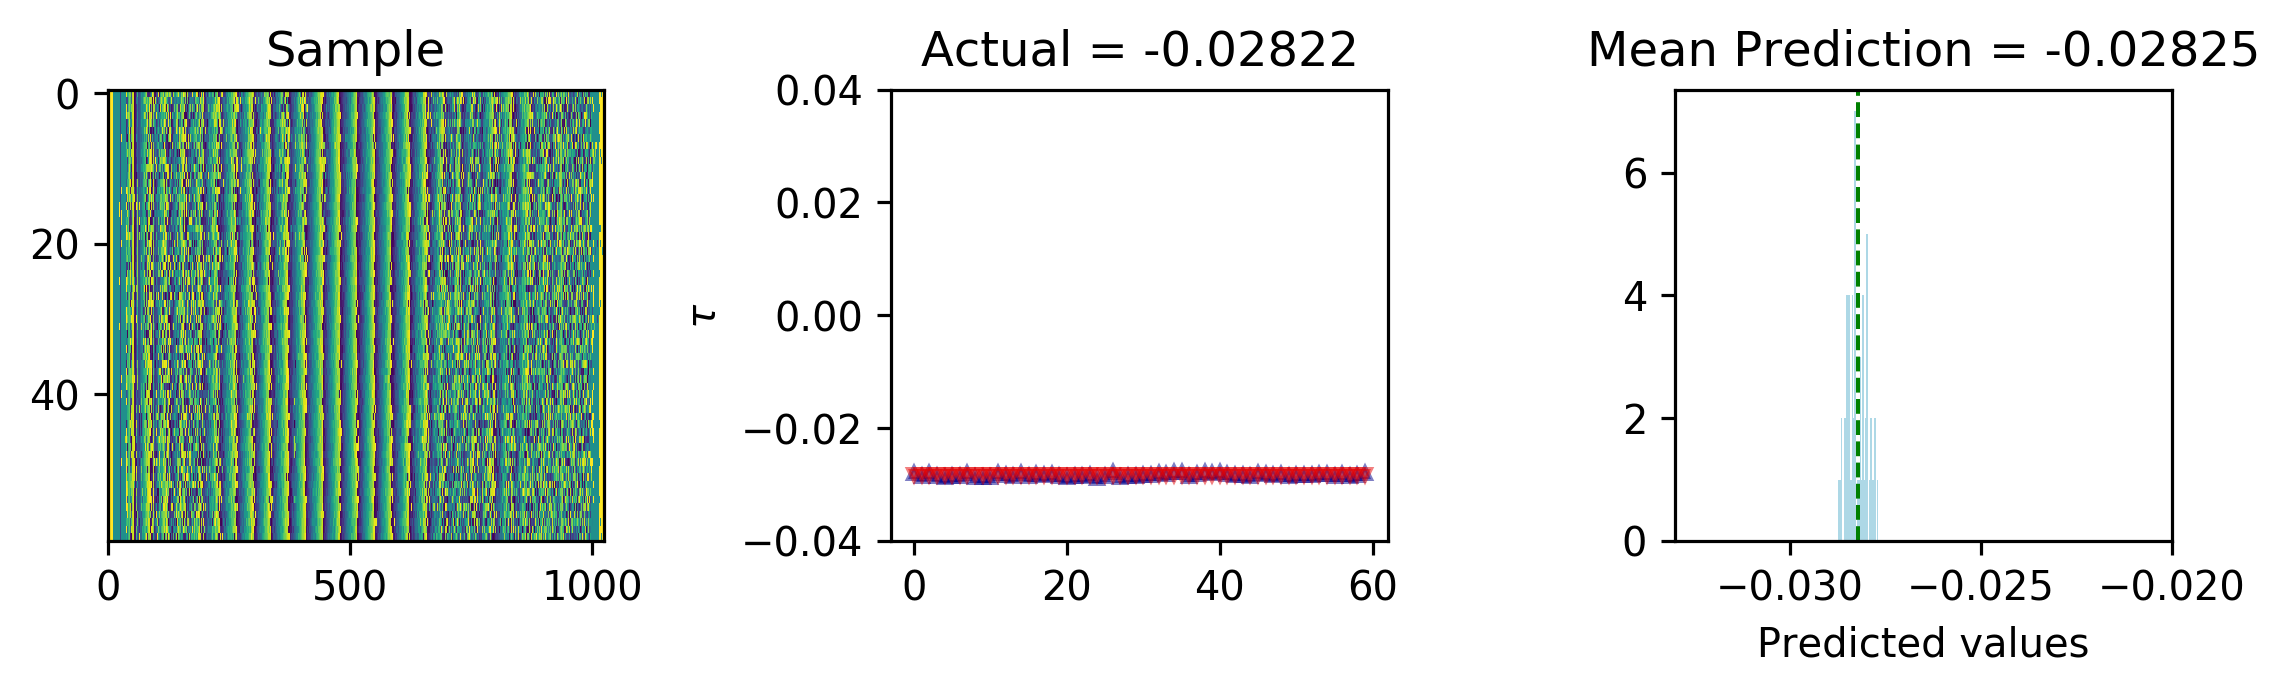

INFO:tensorflow:Restoring parameters from logs/FaoraCopy-A/trained_model.ckpt-2549


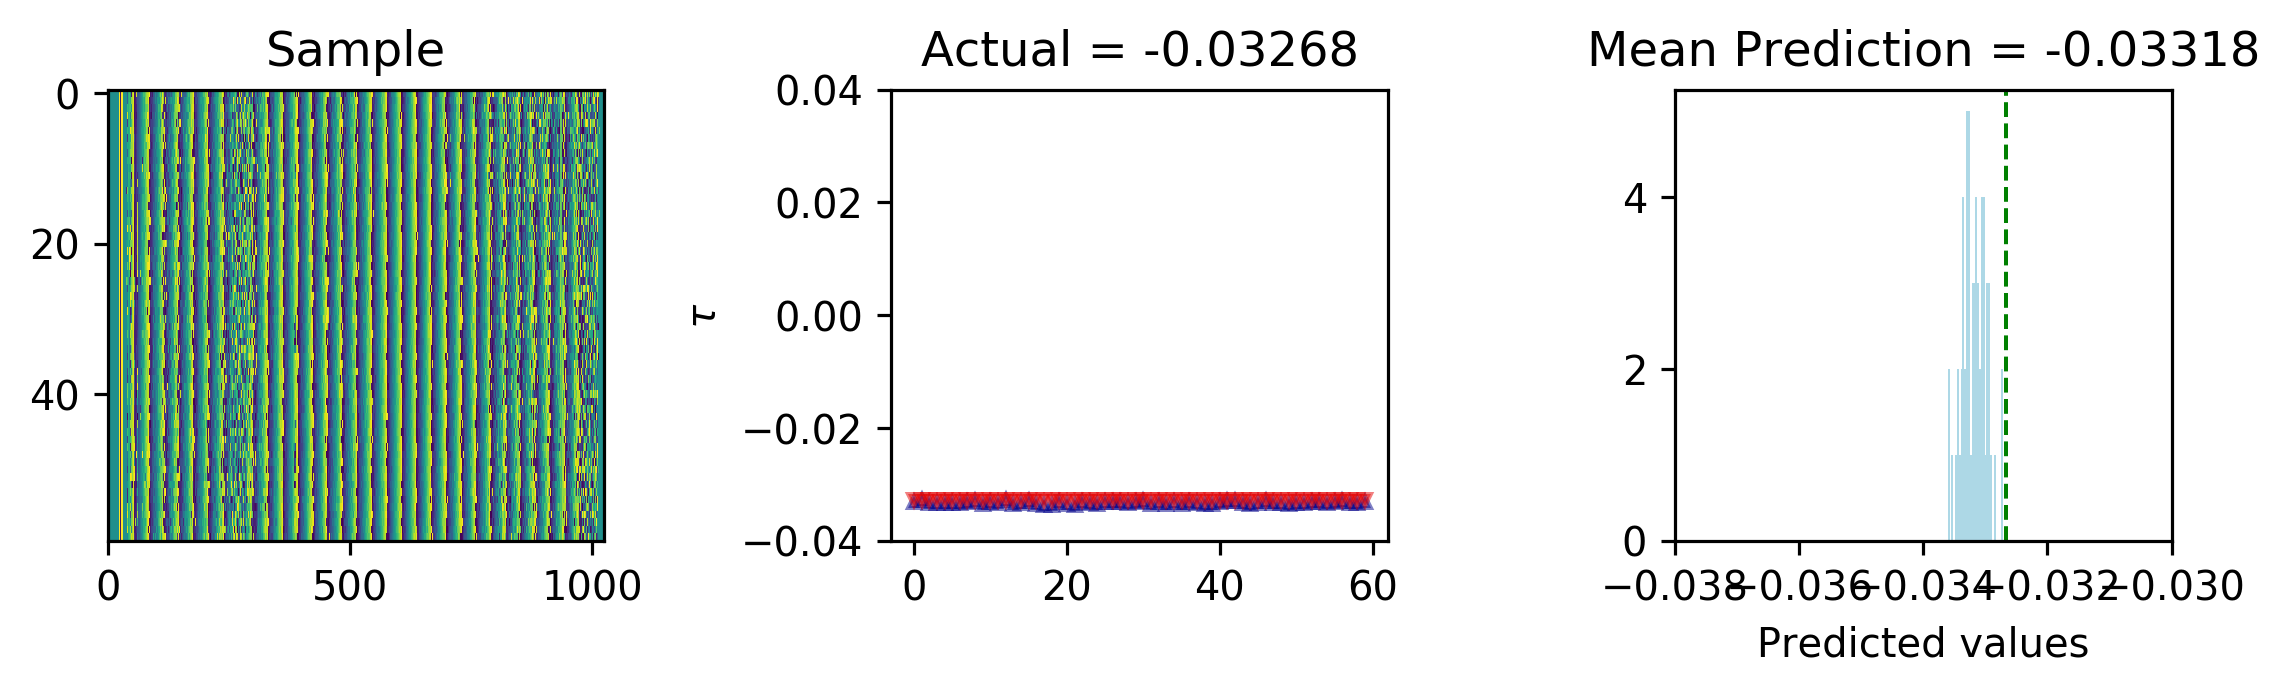

INFO:tensorflow:Restoring parameters from logs/FaoraCopy-A/trained_model.ckpt-2549


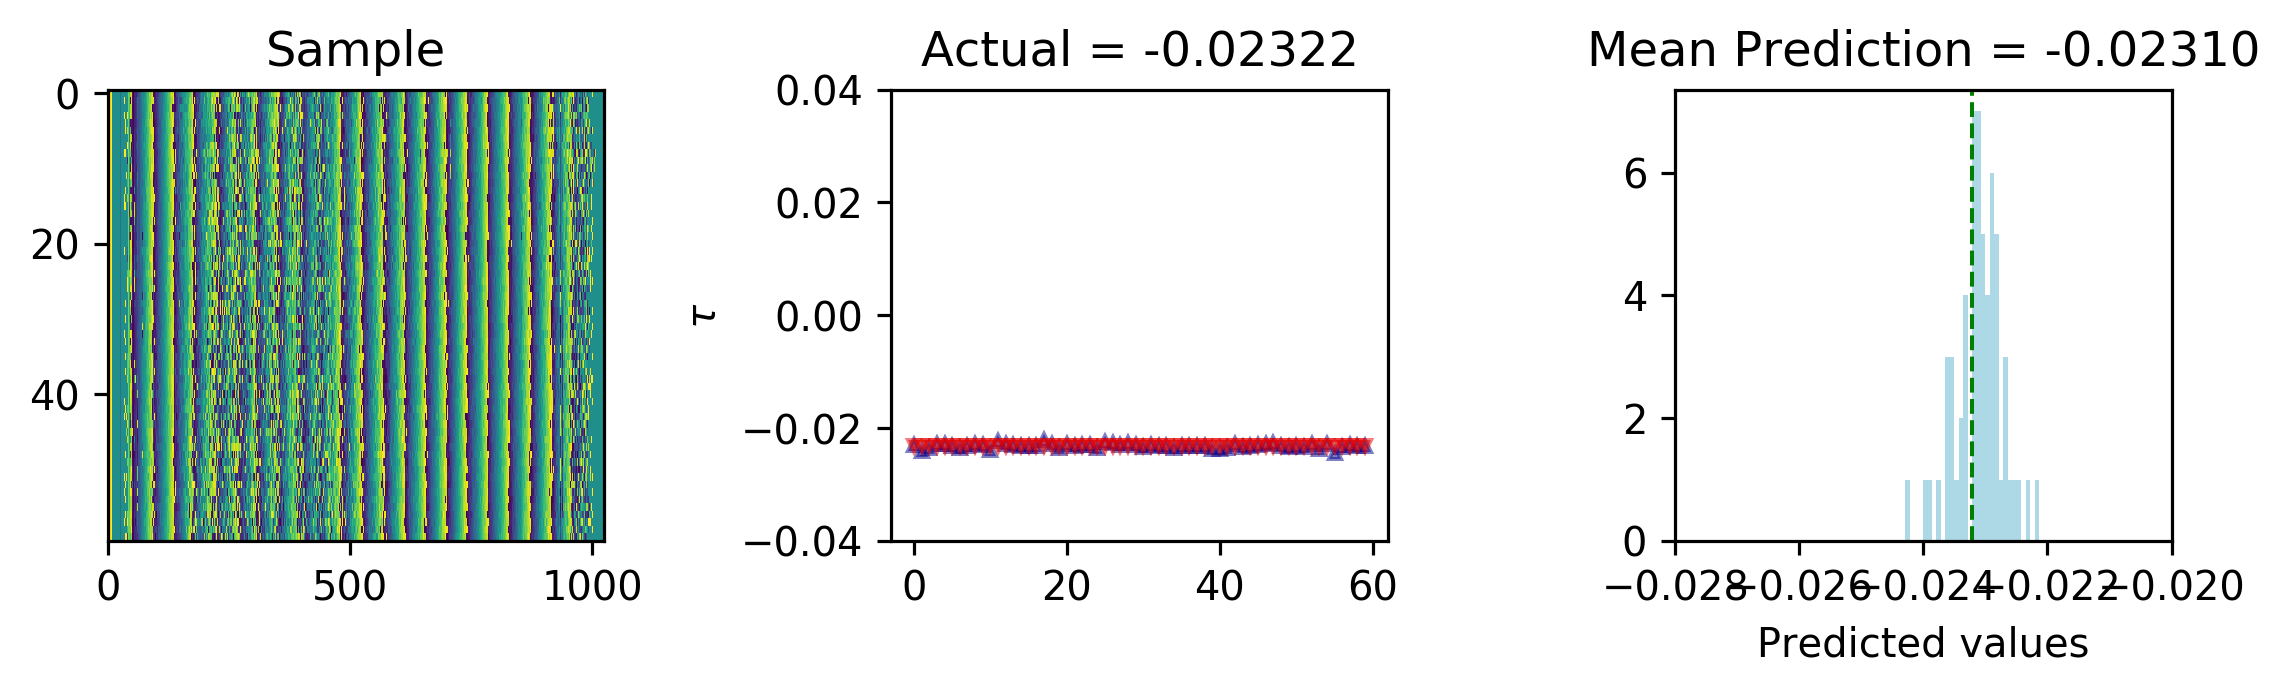

INFO:tensorflow:Restoring parameters from logs/FaoraCopy-A/trained_model.ckpt-2549


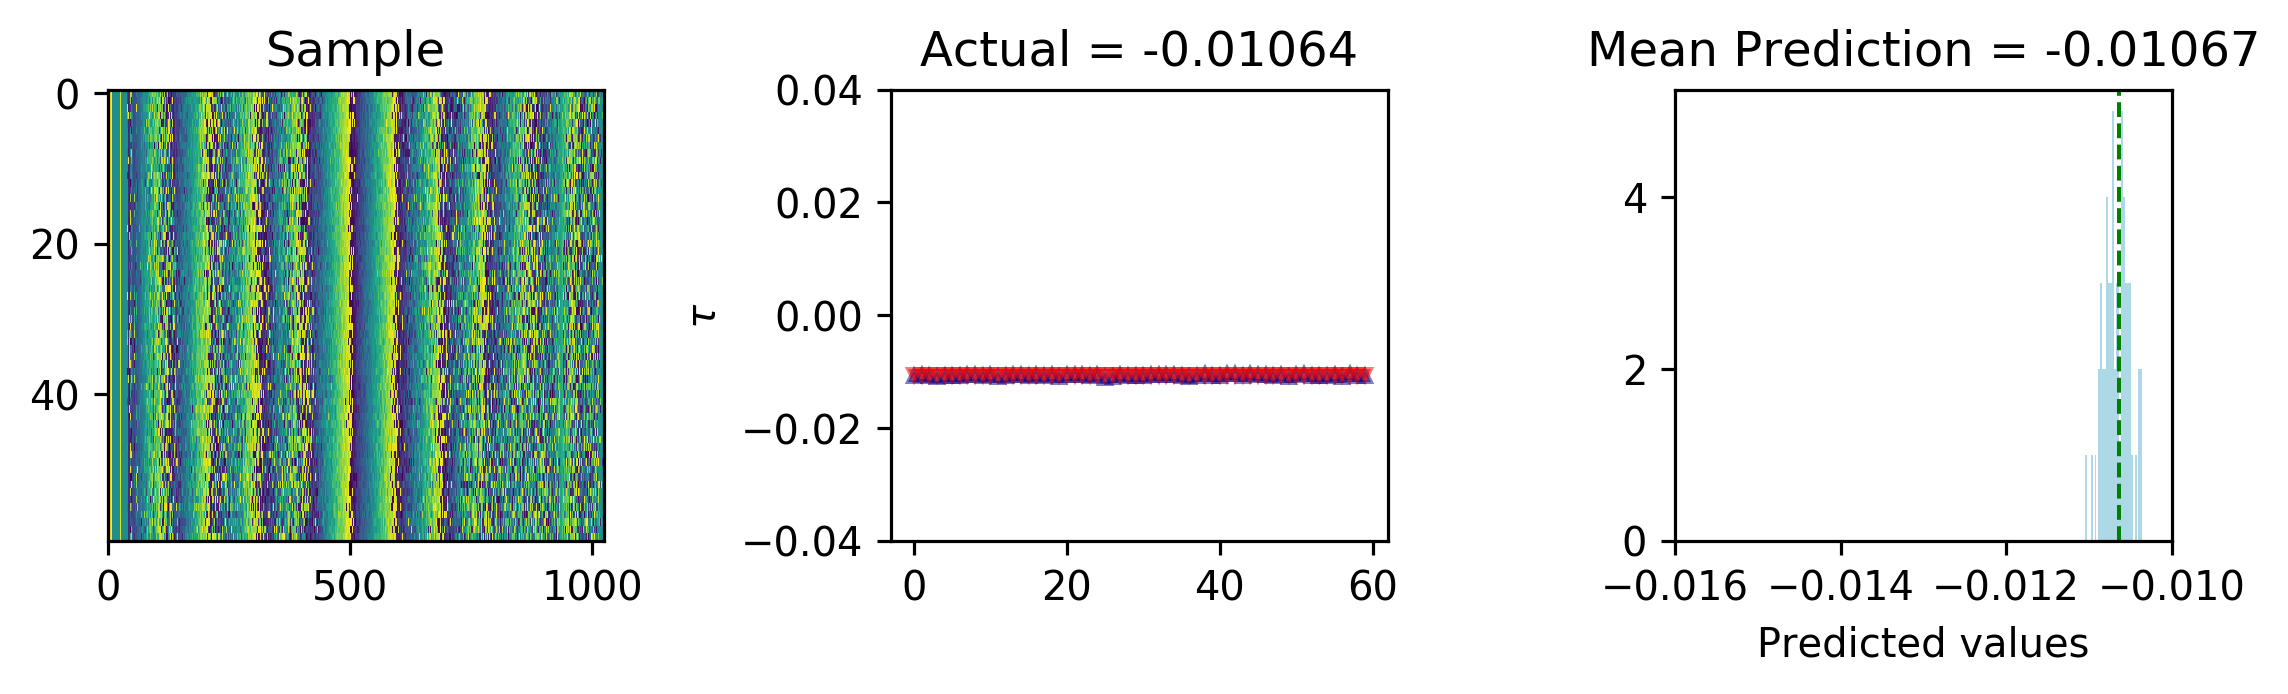

INFO:tensorflow:Restoring parameters from logs/FaoraCopy-A/trained_model.ckpt-2549


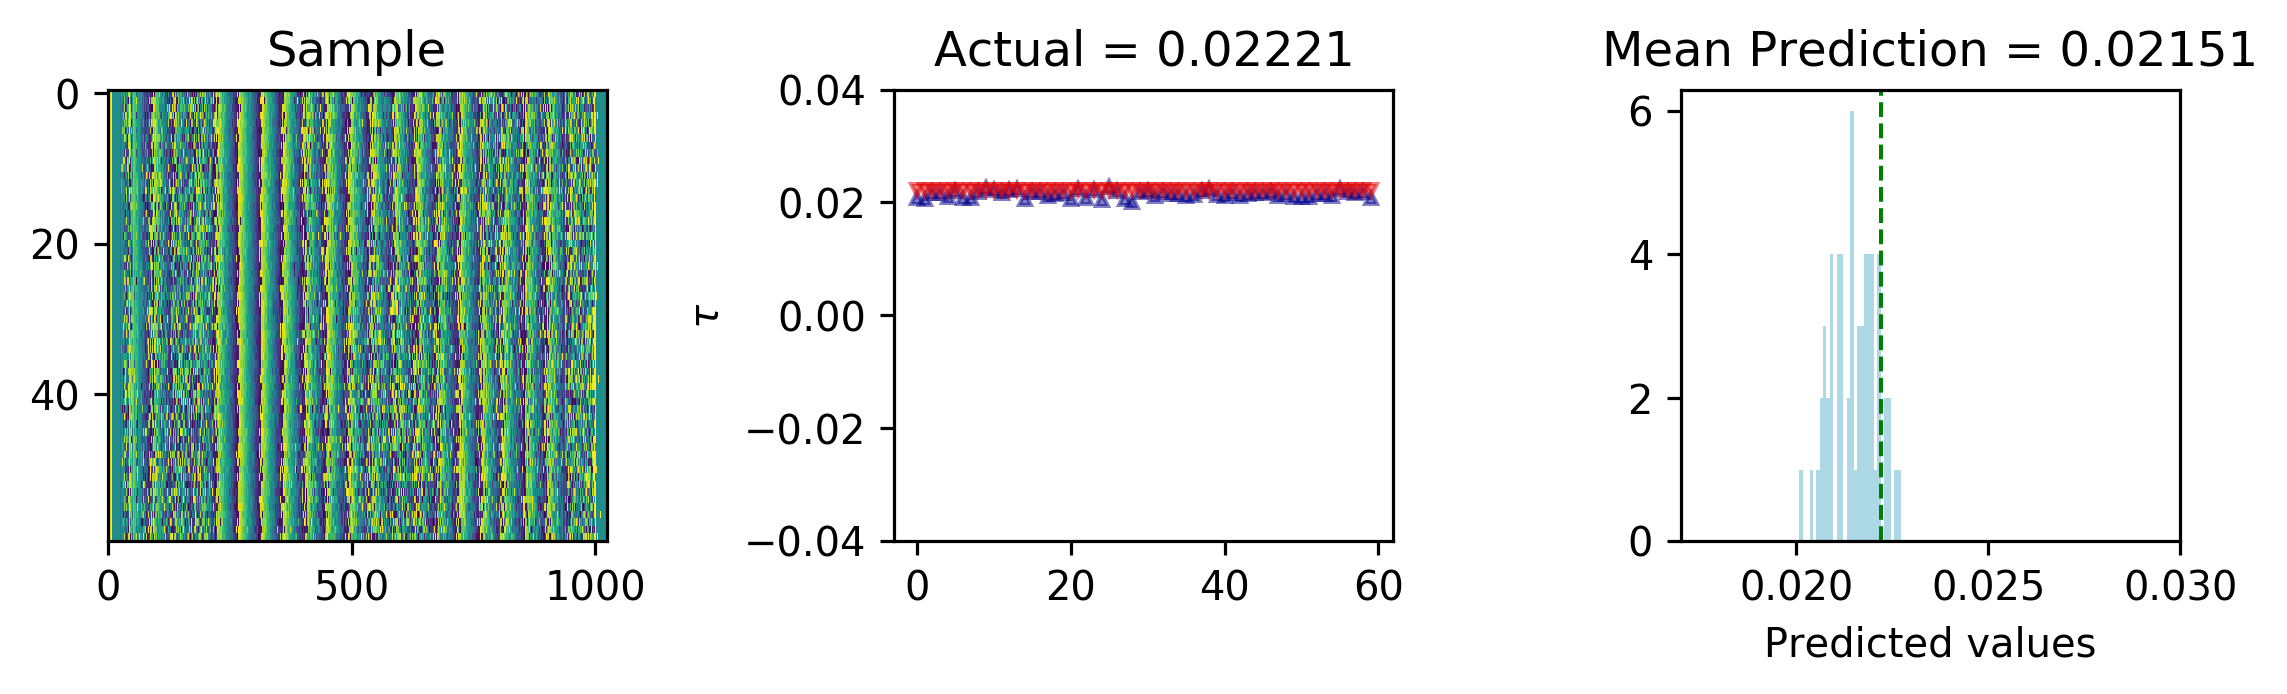

In [103]:
for _ in range(25):
    __ = check_one(plot = True)

***
#### Imports

In [62]:
# hera stuff
import hera_cal as hc
import pyuvdata
import aipy
import uvtools

# general
import numpy as np
import random
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import sys, io # output flushing

import tensorflow as tf
from scipy.optimize import curve_fit

***
##### Data

In [2]:
# load in data for a JD. 
data_directory = '../zen_data/'
miriad_path = data_directory + 'zen.2458098.58037.xx.HH.uv'

uvd = pyuvdata.UVData()
uvd.read_miriad(miriad_path)

# gains for same data 
calfits_path = data_directory + 'zen.2458098.58037.xx.HH.uv.abs.calfits'
gains, flags = hc.io.load_cal(calfits_path)

# get the redundancies for that data
aa = hc.utils.get_aa_from_uv(uvd)
info = hc.omni.aa_to_info(aa)
red_bls = np.array(info.get_reds())

In [3]:
# sometimes the antennas are bad, make sure they are good
def ants_good(bl, gain_keys):
    """Returns True if both antennas are in gains.keys"""
    ants = [a[0] for a in gain_keys] # gain_keys is a list of tuples like (ant, pol)
    if bl[0] in ants and bl[1] in ants:
        return True
    else:
        return False
# ants_good(rnd_bl, gains.keys())

In [4]:
# lets make sure ahead of time that none of the lists in red_bls are made up of only bad antennas
x = 0
bad_indices = []
for i, bls in enumerate(red_bls):
    for bl in bls:
        if ants_good(bl, gains.keys()) == True:
            pass
        else:
            x += 1
    if len(bls) == x:
        bad_indices.append(i)
    x = 0
good_red_bls = np.delete(red_bls, bad_indices)

# to get a random bls
random_red_bls = lambda : np.random.choice(good_red_bls)

In [5]:
def gen_flatness_from_good_red_bls(good_red_bls):

    num_keys = 0
    while num_keys < 2:

        data = {bl: uvd.get_data(bl) for bl in np.random.choice(good_red_bls) if ants_good(bl, gains.keys())}
        num_keys = len(data.keys())
        
    rnd_keys = random.sample(data.keys(), 2)
    
    a, b = rnd_keys[0][0], rnd_keys[0][1]
    c, d = rnd_keys[1][0], rnd_keys[1][1]
    S = data[a, b]*data[c, d].conjugate() * gains[(a,'x')].conjugate() * gains[(b,'x')] * gains[(c,'x')] * gains[(d,'x')].conjugate()
 
    return S

In [6]:
def gen_mega_flatness(good_red_bls, num = 250):
    mega_S = []
    for _ in range(num):
        mega_S.append(gen_flatness_from_good_red_bls(good_red_bls))
    return np.concatenate(mega_S, axis = 0)

In [7]:
# data scaling
def delay_tx(delay, min_d = -0.040, max_d = 0.040):
    return (delay + abs(min_d)) / (abs(max_d) + abs(min_d))

def delay_itx(scaled_delay, min_d = -0.040, max_d = 0.040):
    
    return scaled_delay*(abs(max_d) + abs(min_d)) - abs(min_d)

def angle_tx(angles):
    return (angles + np.pi) / (2 * np.pi)

def angle_itx(scaled_angles):
    return scaled_angles*2.*np.pi - np.pi

***
#### NN

In [8]:
number_of_inputs  = 1024
number_of_outputs =  1
layer_nodes = [512,256,128,128,128,64,64,32,32]
learning_rate = 0.00001
testing_data_percentage = 0.20
keep_prob_rate = 0.50
model_save_interval = 50

In [9]:
class NN(object):
    
    def __init__(self, layer_nodes, number_of_inputs, number_of_outputs, learning_rate):
        
        tf.reset_default_graph()
        
        with tf.variable_scope('input_X'):
            self.X  = tf.placeholder(tf.float32, shape = (None, number_of_inputs))
    
        with tf.variable_scope('input_y'):
            self.y  = tf.placeholder(tf.float32, shape = (None, 1))
            
        with tf.variable_scope('keep'):
            self.keep_prob = tf.placeholder(tf.float32)
            
        layers = []
        with tf.variable_scope('input_layer'):
            b = tf.get_variable(name = 'biases_input',
                                shape = [layer_nodes[0]],
                                initializer = tf.zeros_initializer())
            
            w = tf.get_variable(name = 'weights_input',
                                shape  = [number_of_inputs, layer_nodes[0]],
                                initializer = tf.contrib.layers.xavier_initializer())
            
            layer = tf.nn.leaky_relu(tf.matmul(self.X, w) + b)
            layers.append(layer)
        
        with tf.variable_scope('dropout'):
            dropout = tf.nn.dropout(layers[0], self.keep_prob)            
            layers.append(dropout)
            
        # hidden layers
        for i in range(len(layer_nodes)):
            if i > 0:
                with tf.variable_scope('layer_%d' %i):
                    b = tf.get_variable(name = 'biases_%d' %i,
                                        shape = [layer_nodes[i]],
                                        initializer = tf.zeros_initializer())
                    
                    w = tf.get_variable(name = 'weights_%d' %i,
                                        shape  = [layer_nodes[i-1], layer_nodes[i]],
                                        initializer = tf.contrib.layers.xavier_initializer())
                    
                    layer = tf.nn.relu6(tf.matmul(layers[i], w) + b)
                    layers.append(layer)
                    
        with tf.variable_scope('output_layer'):
            b = tf.get_variable(name = "biases_out",
                                shape = [number_of_outputs],
                                initializer = tf.zeros_initializer())
            
            w = tf.get_variable(name = "weights_out",
                                shape  = [layer_nodes[-1], number_of_outputs],
                                initializer = tf.contrib.layers.xavier_initializer())
            
            self.prediction = tf.nn.relu6(tf.matmul(layers[-1], w) + b)
            
        with tf.variable_scope('cost'):

            self.cost = tf.reduce_mean(tf.squared_difference(self.prediction, self.y))
            
        with tf.variable_scope('acc_test'):
            self.acc_test = tf.placeholder(tf.float32)
            
        with tf.variable_scope('acc_2'):
            sigma = 0.00625
            dist = tf.contrib.distributions.Normal(0., sigma)
            self.acc = tf.reduce_mean(tf.divide(1.,1. + dist.prob(self.prediction - self.y)))
        
        with tf.variable_scope('train'):
            self.optimizer = tf.train.AdamOptimizer(learning_rate, epsilon=1e-08).minimize(self.acc)

        with tf.variable_scope('image'):
            self.image_buf = tf.placeholder(tf.string, shape=[])
            epoch_image = tf.expand_dims(tf.image.decode_png(self.image_buf, channels=4), 0)
            
        with tf.variable_scope('logging'):                                                                                
            
            tf.summary.image('prediction_vs_actual', epoch_image)
            tf.summary.histogram('predictions', self.prediction)
            tf.summary.scalar('current_cost', self.cost)
            tf.summary.scalar('acc', self.acc)
            tf.summary.scalar('accuracy_005', self.acc_test)
            self.summary = tf.summary.merge_all()

***
###### To Check results

In [10]:
def gaussian(x, mu, sigma,A):
    return A*((2.*np.pi*sigma**2)**(-1./2.))*np.exp(-((x-mu)**2/(2*sigma**2)))

In [86]:
def checker(num = 1000, num_bins = 60):
    """check a number of samples"""
    checks = []
    saver = tf.train.Saver()
    with tf.Session() as session:

        saver.restore(session,'logs/FaoraCopy-A/trained_model.ckpt-2549')

        for iii in range(num):
            sys.stdout.write('\r%4.0d'%iii)
            test_S = gen_flatness_from_good_red_bls(good_red_bls)

            test_delay = np.random.uniform(low = -.040, high = 0.040)
            tester = test_S * np.exp(-2*np.pi*1j*(test_delay*nu + np.random.uniform()))

            inputs = np.angle(tester)
            outputs = np.ones((60,1))*test_delay
            inputs = angle_tx(inputs)
            outputs = delay_tx(outputs)

            prediction_scaled_test = session.run(network.prediction,feed_dict = {network.X: inputs,network.keep_prob : 1.00})


            prediction_unscaled = delay_itx(prediction_scaled_test.T[0])
            output_unscaled = delay_itx(outputs.T[0])
            sorting_idx = np.argsort(output_unscaled)
            actl = output_unscaled[sorting_idx]
            pred = prediction_unscaled[sorting_idx]    

            entries, edges = np.histogram(pred,bins = num_bins)
            bin_centers = 0.5 * (edges[:-1] + edges[1:])   

            try:
                popt,pcov = curve_fit(gaussian,bin_centers,entries)
                fit_pred = popt[0]
                sigma = popt[1]
            except:
                sigma = None

            actual = test_delay; prediction_value = np.mean(pred) if sigma == None else fit_pred
            checks.append((actual,prediction_value, sigma))
    return checks

In [84]:
def check_one(delay = None, num_bins = 20, perfect_flat = False, plot = False):
    """check a single sample"""

    
    if perfect_flat == True:
        test_S = np.ones((60,1024))
    else:
        test_S = gen_flatness_from_good_red_bls(good_red_bls)

    if delay == None:
        test_delay = np.random.uniform(low = -.040, high = 0.040)
    else:
        test_delay = delay
        
    tester = test_S * np.exp(-2*np.pi*1j*(test_delay*nu + np.random.uniform()))

    
    saver = tf.train.Saver()
    with tf.Session() as session:

        saver.restore(session,'logs/FaoraCopy-A/trained_model.ckpt-2549')

        inputs = np.angle(tester)
        outputs = np.ones((60,1))*test_delay
        inputs = angle_tx(inputs)
        outputs = delay_tx(outputs)


        prediction_scaled_test = session.run(network.prediction,
                                             feed_dict = {network.X: inputs,
                                                          network.keep_prob : 1.00})
        

    prediction_unscaled = delay_itx(prediction_scaled_test.T[0])
    output_unscaled = delay_itx(outputs.T[0])
    sorting_idx = np.argsort(output_unscaled)
    actl = output_unscaled[sorting_idx]
    pred = prediction_unscaled[sorting_idx]

    if plot == True:
        fig, ax = plt.subplots(1,3, figsize = (8,2.5), dpi = 144)
        
        ax[0].imshow(np.angle(tester), aspect = 'auto')
        ax[0].set_title('Sample')

        ax[1].set_title('Actual = %.5f' %test_delay)
        ax[1].set_ylabel(r'$\tau$')
        ax[1].plot(pred, ls = 'None', marker = '^', markersize = 3, color = 'darkblue', alpha = 0.5, label = 'Prediction')
        ax[1].plot(actl, ls = 'None', marker = 'v', markersize = 3,  color = '#E50000', alpha = 0.5, label = 'Actual')       
        ax[1].set_ylim(-0.040,0.040)
#         ax[1].legend()
    
#     entries, edges = np.histogram(pred-actl,bins = num_bins)

#     bin_centers = 0.5 * (edges[:-1] + edges[1:])
    def gaussian(x, mu, sigma,A):
        return A*((2*np.pi*sigma**2)**(-1/2))*np.exp(-((x-mu)**2/(2*sigma**2)))
    
    entries, edges = np.histogram(pred,bins = num_bins)
    bin_centers = 0.5 * (edges[:-1] + edges[1:])
    if plot == True:
        try:
            
            popt,pcov = curve_fit(gaussian,bin_centers,entries)

            ax[2].plot(np.linspace(-.08,.08,10020),
                    gaussian(np.linspace(-.08,.08,10020),*popt),
                    color = '#E50000', lw = 1)
            ax[2].set_title(r'Prediction: $\mu$ = %.5f, $\sigma$ = %.5f' %(popt[0], popt[1]))
        except:
            ax[2].set_title('Mean Prediction = %.5f'%np.mean(pred))

            pass
#         ax[2].set_title('Mean Prediction = %.5f'%np.mean(pred))

        ax[2].hist(pred,
                bins = 30,
                color = 'lightblue')
        ax[2].axvline(test_delay, lw = 1, color = 'green', ls = '--')
        ax[2].set_xlabel('Predicted values')
        ax[2].set_xlim(np.round(test_delay - .005, 3),np.round(test_delay + .005, 2))
        plt.tight_layout()
        plt.show()
    
#     try:
#         pass
# #         popt,pcov = curve_fit(gaussian,bin_centers,entries)
# #         sigma = popt[1]
#     except:
#         sigma = None
    sigma = None
    actual = test_delay; mean_prediction = np.mean(pred)
    return actual, mean_prediction, sigma